In [1]:
import sys
import os

import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG=True
from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import rdChemReactions
from rdkit.Chem import rdqueries # faster than iterating atoms https://sourceforge.net/p/rdkit/mailman/message/34538007/ 
from rdkit.Chem.rdchem import Atom
from rdkit import DataStructs
import numpy as np
np.random.seed(0)

from itertools import chain
import random
random.seed(0)

from tqdm import tqdm
import csv
import re 
import pickle
import copy

## Generator outline: 
- load rxn SMILES (reactants>reagents>product) 
- remove reagents (reactants>>product)
- select 1 positive rxn from dataset
- find a few ways to generate a bunch of negative rxns 
- do contrastive learning 

## Ideas: (initial data augmentation even b4 passing thru model) 
- randomly pick & change atom(s) in prod (& corresp. atoms in rcts): DONE
- change leaving groups in reactants (change entire groups + indiv atoms)  
- identify rxn centre, and change those atoms 
<br> <br>
- similarity metrics to find similar rxn to be modified? (computational time may be problematic)
<br> <br> 
- train a model to generate fake reactions? but not exactly like GANs, since we don't want feasible rxn, but bad/ambiguous rxns

### cleaned pickle files can be found: 
https://drive.google.com/drive/folders/1leQJK2W5up2zzkM5fRFSANYvY7P1rppK?usp=sharing

In [2]:
with open(os.getcwd()+'/USPTO_STEREO_pickles/clean_rxn.pickle', 'rb') as handle:
    clean_rxn_nomap = pickle.load(handle)

## Idea 1: randomly chooses an atom in pdt & changes its element 
pro's: 
- even if nonsensical, makes model learn which elemental atoms belong where (and where not) in a molecule <br>

con's: 
- have to restrict choice of new element? (e.g. transition metals are almost always catalysts rather than reactants) --> **solution**: could just take this pool to be all elements present in our given dataset? (use a function) 
- is chemical balance necessary? is it ok to just change product? bcos **atom mapping** may not be present in all datasets. this function needs atom mapping --> **solution**: are there any other ways to identify corresponding atom?? perhaps by using some substructure match? not sure. The need for atom mapping is not good as it restricts dataset choice & may be considered semi-template based (Google's energy-based retro paper)

factors to consider:  
- what if # atoms to change > # changeable atoms? e.g. if molecule is very small & has restrictions, like aromatic ring --> **solved** implement MaxTries counter
<br> <br>

- (needs atom mapping) identify rxn centre, then do not touch the rxn centre (in both rct & pdt) but this might not be informative (we don't know how reactivity changes if some distant atom is changed)
- but also have some examples that change the rxn centre atoms?? 
- how to ensure diversity (& affinity) of augmentation (Sam's talk)
<br> <br>

- make separate lists containing elements of specific valences (e.g. ele_valence_3 = ['P', 'N', ...]) --> new element Valence must >= old element valence --> reduce failure rate (might still not work in special cases, like meeting aromaticity requirements) 
- but problem is some elements have multiple plausible valences

In [3]:
# feels a bit too much intervention. alternative is to take all elements present in reactant side in dataset 

all_ele = np.arange(1, 104)
too_rare = np.concatenate([np.array([43, 84, 85, 87, 88]), np.arange(109, 119)]) 
# Tc, Po, At, Fr, Ra + Rf, Db, ... Mt, Ds, ... Og

halo = [9, 17, 35, 53] 
grp1 = [3, 11, 19, 37, 55]
grp2 = [4, 12, 20, 38, 56]
tm = np.concatenate([np.arange(21, 31), np.arange(39, 49), np.arange(72, 81)])
metal_rcts = [3, 12, 29, 30, 80] # metals that can be reactants like Grignard, organocuprates etc. 
lanth = np.arange(57, 72)
acti = np.arange(89, 104)
noble = [2, 10, 18, 36, 54, 86]

refined_ele = [ele for ele in all_ele if ((ele not in too_rare) and 
                                          (ele not in noble) and 
                                          (ele not in grp1) and 
                                          (ele not in grp2) and
                                          (ele not in lanth) and 
                                          (ele not in acti) and 
                                          (ele not in tm))]
refined_ele = list(set(refined_ele) | set(metal_rcts))
len(refined_ele)

29

In [14]:
# v3 --> checks for reactant atom chemical correctness IMMEDIATELY after changing prod atom 
def change_rdm_atom_tgt_v3(rxn_smi, ele_list, counts=1, toprint=False, maxtries=100, keep_reagent=False):
    '''
    naively & randomly chooses an atom in prod & changes it to another random element,
    and also changes atom-mapped reactant atom to that chosen element (for chemical balance)
    
    rxn_smi: reaction SMILES in the form 'reactants>>product'
    ele_list: list of atomic numbers to be randomly picked from
    counts: # of atoms in prod to be changed
    toprint: whether to print info about changed atoms
    maxtries: # of tries until func gives up and returns original rxn 
    keep_reagent: if True, returns rxn_smi w/ reagent(s) if originally present
    '''
    prod_smi = rxn_smi.split('>')[-1]
    rcts_smi = rxn_smi.split('>')[0].split('.')
    
    rcts_mol = [Chem.MolFromSmiles(rct_smi) for rct_smi in rcts_smi]
    rcts_molw = [Chem.RWMol(rct_mol) for rct_mol in rcts_mol]
    rcts_molw_cand = copy.deepcopy(rcts_molw)
    
    prod_mol = Chem.MolFromSmiles(prod_smi)
    prod_molw = Chem.RWMol(prod_mol)
    prod_molw_cand = copy.deepcopy(prod_molw)
    atom_idxs = list(range(0, prod_mol.GetNumAtoms())) # it is possible to impose restrictions here (e.g. non aromatic only)
    
    iters = 0
    for count in np.arange(counts): 
        valid = False
        while not valid and iters < maxtries: # try while loop first, BUT not computationally efficient? 
            try: 
                rdm_atom_idx = random.choice(atom_idxs)
                rdm_ele = int(random.choice(ele_list))
                
                # change product atom
                prod_molw_cand.ReplaceAtom(rdm_atom_idx, Chem.Atom(rdm_ele), True, True)
                Chem.SanitizeMol(prod_molw_cand)
                if toprint:
                    print('rdm_atom_idx, rdm_ele:', rdm_atom_idx, rdm_ele)
                
                atom_map = prod_molw_cand.GetAtomWithIdx(rdm_atom_idx).GetProp('molAtomMapNumber')
                
                # find corresp. rct atom and change it to same element
                query_atom = rdqueries.HasIntPropWithValueQueryAtom('molAtomMapNumber', int(atom_map))
                match_atom = [rct_molw.GetAtomsMatchingQuery(query_atom) for rct_molw in rcts_molw_cand
                              if len(rct_molw.GetAtomsMatchingQuery(query_atom)) == 1]
                match_rct = Atom.GetOwningMol(match_atom[0][0]) # retrieves original pointer to rct molecule  
                match_rct.ReplaceAtom(match_atom[0][0].GetIdx(), Chem.Atom(rdm_ele), True, True)
                Chem.SanitizeMol(match_rct)
                               
                valid = True
            except:
                if toprint:
                    print('SanitizeMol failed')
                prod_molw_cand = copy.deepcopy(prod_molw) # reset candidates 
                rcts_molw_cand = copy.deepcopy(rcts_molw)
                iters += 1
                continue
        
        rcts_molw = copy.deepcopy(rcts_molw_cand)
        prod_molw = copy.deepcopy(prod_molw_cand) # successful candidate  
        atom_idxs.remove(rdm_atom_idx) # avoid changing the same atom more than once
        
    prod_smi = Chem.MolToSmiles(prod_molw, True)
    rcts_smi = [Chem.MolToSmiles(rct_molw, True) for rct_molw in rcts_molw]
    
    if keep_reagent:
        reag_smi = rxn_smi.split('>')[1]
        return '{}>{}>{}'.format('.'.join(rcts_smi), reag_smi, prod_smi)
    else:
        return '{}>>{}'.format('.'.join(rcts_smi), prod_smi)

### Example 1: 

In [28]:
sample_rxn_smi = 'CC(=O)OC(C(=O)[NH:13][C@H:10]1[C@@H:9]2[N:8]([C:7]([C:29](=[O:30])[OH:31])=[C:6]([CH2:5]OC(C)=O)[CH2:28][S:27]2)[C:11]1=[O:12])c1ccccc1>>[CH3:5][C:6]1=[C:7]([C:29](=[O:30])[OH:31])[N:8]2[C@@H:9]([C@H:10]([NH2:13])[C:11]2=[O:12])[S:27][CH2:28]1'
changed_rxn_smi = change_rdm_atom_tgt_v3(sample_rxn_smi, refined_ele, 5, toprint=True)
changed_rxn_smi

SanitizeMol failed
rdm_atom_idx, rdm_ele: 6 81
rdm_atom_idx, rdm_ele: 13 29
rdm_atom_idx, rdm_ele: 12 53
rdm_atom_idx, rdm_ele: 9 9
SanitizeMol failed
rdm_atom_idx, rdm_ele: 8 50
SanitizeMol failed
rdm_atom_idx, rdm_ele: 4 32


'CC(=O)OC(C(=O)[NH:13][SnH:10]1[C@@H:9]2[Tl:8]([C:7]([C:29](=[GeH2:30])[OH:31])=[C:6]([CH2:5]OC(C)=O)[Cu:28][I:27]2)[C:11]1=[O:12])c1ccccc1>>[CH3:5][C:6]1=[C:7]([C:29](=[GeH2:30])[OH:31])[Tl:8]2[C@@H:9]([SnH:10]([NH2:13])[C:11]2=[O:12])[I:27][Cu:28]1'

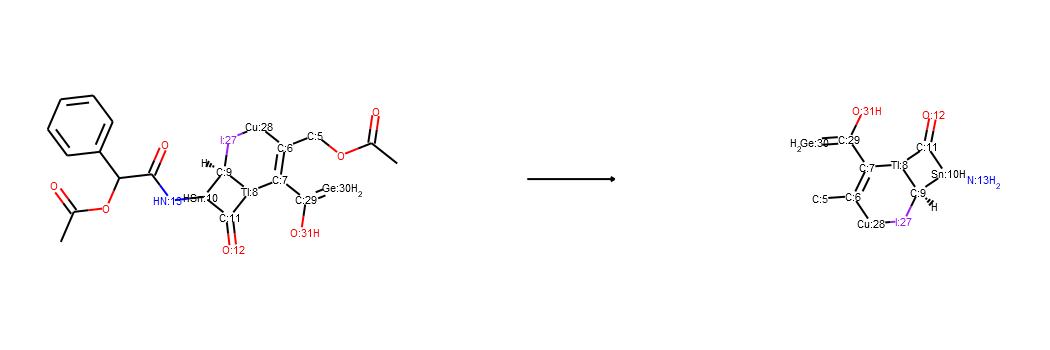

In [29]:
Draw.ReactionToImage(rdChemReactions.ReactionFromSmarts(changed_rxn_smi, useSmiles=True), (350, 350))

### speed of v3 function
- 19.2 s for 10,000 iterations (all transition metals were allowed) 
- 20.7 s for 10,000 iterations (total 29 element choices, only a few transiton metals allowed) 

In [23]:
%%time 

sample_rxn_smi2 = '[C:2]([CH3:3])([CH3:4])([CH3:5])[NH:6][NH2:7].[C-:8]#[N:9].O=[C:12]1[CH2:13][CH2:14][CH2:15][CH2:16][CH2:17]1>C(O)C.Cl.[Na+].O>[C:2]([CH3:3])([CH3:4])([CH3:5])[NH:6][NH:7][C:12]1([C:8]#[N:9])[CH2:13][CH2:14][CH2:15][CH2:16][CH2:17]1'
for i in range(10000):
    change_rdm_atom_tgt_v3(sample_rxn_smi2, refined_ele, 3, True)
    print('molecule {} done \n'.format(i))

rdm_atom_idx, rdm_ele: 1 34
rdm_atom_idx, rdm_ele: 2 8
SanitizeMol failed
rdm_atom_idx, rdm_ele: 4 16
molecule 0 done 

rdm_atom_idx, rdm_ele: 0 29
rdm_atom_idx, rdm_ele: 11 83
rdm_atom_idx, rdm_ele: 10 80
molecule 1 done 

rdm_atom_idx, rdm_ele: 10 81
SanitizeMol failed
rdm_atom_idx, rdm_ele: 1 32
rdm_atom_idx, rdm_ele: 5 31
molecule 2 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 9 49
rdm_atom_idx, rdm_ele: 8 7
rdm_atom_idx, rdm_ele: 4 80
molecule 3 done 

rdm_atom_idx, rdm_ele: 5 83
rdm_atom_idx, rdm_ele: 2 53
rdm_atom_idx, rdm_ele: 12 6
molecule 4 done 

rdm_atom_idx, rdm_ele: 4 7
rdm_atom_idx, rdm_ele: 11 81
rdm_atom_idx, rdm_ele: 13 6
molecule 5 done 

rdm_atom_idx, rdm_ele: 12 82
rdm_atom_idx, rdm_ele: 2 9
rdm_atom_idx, rdm_ele: 4 16
molecule 6 done 

rdm_atom_idx, rdm_ele: 4 5
rdm_atom_idx, rdm_ele: 3 33
rdm_atom_idx, rdm_ele: 1 81
molecule 7 done 

rdm_atom_idx, rdm_ele: 11 13
rdm_atom_idx, rdm_ele: 2 17
rdm_atom_idx, rdm_ele: 7 53
molecule 8 done 

SanitizeMol failed
rdm_a

rdm_atom_idx, rdm_ele: 3 3
rdm_atom_idx, rdm_ele: 0 13
molecule 90 done 

rdm_atom_idx, rdm_ele: 10 53
rdm_atom_idx, rdm_ele: 5 34
rdm_atom_idx, rdm_ele: 13 12
molecule 91 done 

rdm_atom_idx, rdm_ele: 2 34
SanitizeMol failed
rdm_atom_idx, rdm_ele: 0 13
rdm_atom_idx, rdm_ele: 7 53
molecule 92 done 

rdm_atom_idx, rdm_ele: 4 6
SanitizeMol failed
SanitizeMol failed
rdm_atom_idx, rdm_ele: 3 8
rdm_atom_idx, rdm_ele: 13 32
molecule 93 done 

rdm_atom_idx, rdm_ele: 0 53
rdm_atom_idx, rdm_ele: 11 32
rdm_atom_idx, rdm_ele: 2 32
molecule 94 done 

rdm_atom_idx, rdm_ele: 13 83
rdm_atom_idx, rdm_ele: 8 5
SanitizeMol failed
rdm_atom_idx, rdm_ele: 9 5
molecule 95 done 

SanitizeMol failed
SanitizeMol failed
SanitizeMol failed
SanitizeMol failed
rdm_atom_idx, rdm_ele: 9 12
rdm_atom_idx, rdm_ele: 8 30
rdm_atom_idx, rdm_ele: 13 34
molecule 96 done 

rdm_atom_idx, rdm_ele: 0 6
SanitizeMol failed
rdm_atom_idx, rdm_ele: 2 32
rdm_atom_idx, rdm_ele: 3 9
molecule 97 done 

rdm_atom_idx, rdm_ele: 1 31
rdm_at

rdm_atom_idx, rdm_ele: 6 53
rdm_atom_idx, rdm_ele: 13 53
molecule 183 done 

rdm_atom_idx, rdm_ele: 6 52
rdm_atom_idx, rdm_ele: 12 32
rdm_atom_idx, rdm_ele: 11 33
molecule 184 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 2 13
rdm_atom_idx, rdm_ele: 3 7
rdm_atom_idx, rdm_ele: 6 14
molecule 185 done 

rdm_atom_idx, rdm_ele: 2 3
SanitizeMol failed
rdm_atom_idx, rdm_ele: 1 29
SanitizeMol failed
rdm_atom_idx, rdm_ele: 9 32
molecule 186 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 2 31
rdm_atom_idx, rdm_ele: 11 53
SanitizeMol failed
SanitizeMol failed
SanitizeMol failed
rdm_atom_idx, rdm_ele: 13 5
molecule 187 done 

rdm_atom_idx, rdm_ele: 7 15
SanitizeMol failed
rdm_atom_idx, rdm_ele: 8 29
rdm_atom_idx, rdm_ele: 2 7
molecule 188 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 6 13
rdm_atom_idx, rdm_ele: 12 12
rdm_atom_idx, rdm_ele: 4 53
molecule 189 done 

rdm_atom_idx, rdm_ele: 12 7
rdm_atom_idx, rdm_ele: 8 16
rdm_atom_idx, rdm_ele: 1 17
molecule 190 done 

rdm_atom_idx, rdm_ele: 

molecule 279 done 

rdm_atom_idx, rdm_ele: 10 5
rdm_atom_idx, rdm_ele: 5 50
rdm_atom_idx, rdm_ele: 4 16
molecule 280 done 

rdm_atom_idx, rdm_ele: 8 83
rdm_atom_idx, rdm_ele: 6 82
rdm_atom_idx, rdm_ele: 7 13
molecule 281 done 

rdm_atom_idx, rdm_ele: 8 51
rdm_atom_idx, rdm_ele: 7 33
SanitizeMol failed
rdm_atom_idx, rdm_ele: 9 30
molecule 282 done 

rdm_atom_idx, rdm_ele: 4 52
rdm_atom_idx, rdm_ele: 5 29
rdm_atom_idx, rdm_ele: 3 34
molecule 283 done 

rdm_atom_idx, rdm_ele: 7 16
rdm_atom_idx, rdm_ele: 1 3
SanitizeMol failed
rdm_atom_idx, rdm_ele: 13 49
molecule 284 done 

rdm_atom_idx, rdm_ele: 12 52
SanitizeMol failed
rdm_atom_idx, rdm_ele: 1 30
rdm_atom_idx, rdm_ele: 11 14
molecule 285 done 

rdm_atom_idx, rdm_ele: 5 80
rdm_atom_idx, rdm_ele: 2 34
rdm_atom_idx, rdm_ele: 1 17
molecule 286 done 

rdm_atom_idx, rdm_ele: 2 31
rdm_atom_idx, rdm_ele: 7 14
SanitizeMol failed
rdm_atom_idx, rdm_ele: 4 49
molecule 287 done 

SanitizeMol failed
SanitizeMol failed
rdm_atom_idx, rdm_ele: 8 83
rdm_

molecule 380 done 

rdm_atom_idx, rdm_ele: 10 7
rdm_atom_idx, rdm_ele: 12 53
rdm_atom_idx, rdm_ele: 11 80
molecule 381 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 7 29
rdm_atom_idx, rdm_ele: 2 1
rdm_atom_idx, rdm_ele: 12 14
molecule 382 done 

rdm_atom_idx, rdm_ele: 12 15
rdm_atom_idx, rdm_ele: 4 33
SanitizeMol failed
rdm_atom_idx, rdm_ele: 0 33
molecule 383 done 

rdm_atom_idx, rdm_ele: 11 7
rdm_atom_idx, rdm_ele: 5 50
rdm_atom_idx, rdm_ele: 3 30
molecule 384 done 

rdm_atom_idx, rdm_ele: 12 83
SanitizeMol failed
rdm_atom_idx, rdm_ele: 0 80
rdm_atom_idx, rdm_ele: 11 34
molecule 385 done 

rdm_atom_idx, rdm_ele: 8 29
rdm_atom_idx, rdm_ele: 0 53
SanitizeMol failed
rdm_atom_idx, rdm_ele: 9 82
molecule 386 done 

rdm_atom_idx, rdm_ele: 1 1
rdm_atom_idx, rdm_ele: 3 34
SanitizeMol failed
rdm_atom_idx, rdm_ele: 9 49
molecule 387 done 

rdm_atom_idx, rdm_ele: 2 8
rdm_atom_idx, rdm_ele: 6 30
rdm_atom_idx, rdm_ele: 1 33
molecule 388 done 

rdm_atom_idx, rdm_ele: 10 53
rdm_atom_idx, rdm_ele

rdm_atom_idx, rdm_ele: 5 12
SanitizeMol failed
SanitizeMol failed
rdm_atom_idx, rdm_ele: 11 7
rdm_atom_idx, rdm_ele: 2 12
molecule 470 done 

rdm_atom_idx, rdm_ele: 7 14
rdm_atom_idx, rdm_ele: 13 50
rdm_atom_idx, rdm_ele: 10 15
molecule 471 done 

rdm_atom_idx, rdm_ele: 12 30
SanitizeMol failed
rdm_atom_idx, rdm_ele: 2 7
rdm_atom_idx, rdm_ele: 0 29
molecule 472 done 

rdm_atom_idx, rdm_ele: 7 13
rdm_atom_idx, rdm_ele: 1 32
rdm_atom_idx, rdm_ele: 9 29
molecule 473 done 

rdm_atom_idx, rdm_ele: 9 7
rdm_atom_idx, rdm_ele: 8 80
rdm_atom_idx, rdm_ele: 6 83
molecule 474 done 

SanitizeMol failed
SanitizeMol failed
rdm_atom_idx, rdm_ele: 6 51
rdm_atom_idx, rdm_ele: 11 15
rdm_atom_idx, rdm_ele: 10 15
molecule 475 done 

rdm_atom_idx, rdm_ele: 2 9
rdm_atom_idx, rdm_ele: 3 50
rdm_atom_idx, rdm_ele: 10 33
molecule 476 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 7 33
rdm_atom_idx, rdm_ele: 0 51
rdm_atom_idx, rdm_ele: 2 32
molecule 477 done 

rdm_atom_idx, rdm_ele: 5 16
rdm_atom_idx, rdm_ele: 

rdm_atom_idx, rdm_ele: 0 13
molecule 559 done 

rdm_atom_idx, rdm_ele: 10 14
rdm_atom_idx, rdm_ele: 2 51
SanitizeMol failed
rdm_atom_idx, rdm_ele: 8 83
molecule 560 done 

rdm_atom_idx, rdm_ele: 1 81
SanitizeMol failed
rdm_atom_idx, rdm_ele: 9 33
rdm_atom_idx, rdm_ele: 3 83
molecule 561 done 

rdm_atom_idx, rdm_ele: 7 53
rdm_atom_idx, rdm_ele: 12 6
rdm_atom_idx, rdm_ele: 1 33
molecule 562 done 

rdm_atom_idx, rdm_ele: 13 82
rdm_atom_idx, rdm_ele: 9 12
rdm_atom_idx, rdm_ele: 4 13
molecule 563 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 10 53
rdm_atom_idx, rdm_ele: 3 34
rdm_atom_idx, rdm_ele: 2 16
molecule 564 done 

rdm_atom_idx, rdm_ele: 7 15
rdm_atom_idx, rdm_ele: 13 12
rdm_atom_idx, rdm_ele: 11 33
molecule 565 done 

rdm_atom_idx, rdm_ele: 4 14
rdm_atom_idx, rdm_ele: 11 16
SanitizeMol failed
rdm_atom_idx, rdm_ele: 6 80
molecule 566 done 

rdm_atom_idx, rdm_ele: 11 14
rdm_atom_idx, rdm_ele: 6 51
SanitizeMol failed
rdm_atom_idx, rdm_ele: 0 83
molecule 567 done 

rdm_atom_idx, rdm_

rdm_atom_idx, rdm_ele: 6 51
SanitizeMol failed
rdm_atom_idx, rdm_ele: 1 50
molecule 657 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 0 32
SanitizeMol failed
SanitizeMol failed
SanitizeMol failed
rdm_atom_idx, rdm_ele: 5 52
rdm_atom_idx, rdm_ele: 1 33
molecule 658 done 

rdm_atom_idx, rdm_ele: 3 83
rdm_atom_idx, rdm_ele: 4 13
rdm_atom_idx, rdm_ele: 1 29
molecule 659 done 

rdm_atom_idx, rdm_ele: 9 32
rdm_atom_idx, rdm_ele: 13 6
rdm_atom_idx, rdm_ele: 1 6
molecule 660 done 

rdm_atom_idx, rdm_ele: 1 15
rdm_atom_idx, rdm_ele: 0 83
rdm_atom_idx, rdm_ele: 3 6
molecule 661 done 

rdm_atom_idx, rdm_ele: 8 49
SanitizeMol failed
rdm_atom_idx, rdm_ele: 13 15
rdm_atom_idx, rdm_ele: 2 9
molecule 662 done 

rdm_atom_idx, rdm_ele: 3 53
rdm_atom_idx, rdm_ele: 5 6
rdm_atom_idx, rdm_ele: 2 15
molecule 663 done 

SanitizeMol failed
SanitizeMol failed
SanitizeMol failed
rdm_atom_idx, rdm_ele: 2 1
SanitizeMol failed
rdm_atom_idx, rdm_ele: 1 81
rdm_atom_idx, rdm_ele: 5 7
molecule 664 done 

rdm_atom_id

rdm_atom_idx, rdm_ele: 12 82
SanitizeMol failed
rdm_atom_idx, rdm_ele: 0 50
molecule 748 done 

rdm_atom_idx, rdm_ele: 10 52
rdm_atom_idx, rdm_ele: 3 33
rdm_atom_idx, rdm_ele: 7 16
molecule 749 done 

rdm_atom_idx, rdm_ele: 5 81
rdm_atom_idx, rdm_ele: 8 80
rdm_atom_idx, rdm_ele: 2 33
molecule 750 done 

rdm_atom_idx, rdm_ele: 13 8
rdm_atom_idx, rdm_ele: 0 83
SanitizeMol failed
SanitizeMol failed
SanitizeMol failed
SanitizeMol failed
rdm_atom_idx, rdm_ele: 11 33
molecule 751 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 1 80
SanitizeMol failed
rdm_atom_idx, rdm_ele: 0 29
rdm_atom_idx, rdm_ele: 5 53
molecule 752 done 

rdm_atom_idx, rdm_ele: 8 30
rdm_atom_idx, rdm_ele: 1 16
SanitizeMol failed
SanitizeMol failed
rdm_atom_idx, rdm_ele: 7 6
molecule 753 done 

SanitizeMol failed
SanitizeMol failed
SanitizeMol failed
rdm_atom_idx, rdm_ele: 9 34
rdm_atom_idx, rdm_ele: 8 6
rdm_atom_idx, rdm_ele: 1 52
molecule 754 done 

rdm_atom_idx, rdm_ele: 5 15
rdm_atom_idx, rdm_ele: 11 7
rdm_atom_idx, r

rdm_atom_idx, rdm_ele: 8 52
rdm_atom_idx, rdm_ele: 1 5
molecule 840 done 

rdm_atom_idx, rdm_ele: 9 50
rdm_atom_idx, rdm_ele: 4 13
rdm_atom_idx, rdm_ele: 1 81
molecule 841 done 

rdm_atom_idx, rdm_ele: 8 30
rdm_atom_idx, rdm_ele: 2 51
rdm_atom_idx, rdm_ele: 13 81
molecule 842 done 

rdm_atom_idx, rdm_ele: 5 50
rdm_atom_idx, rdm_ele: 4 51
rdm_atom_idx, rdm_ele: 3 81
molecule 843 done 

rdm_atom_idx, rdm_ele: 5 81
rdm_atom_idx, rdm_ele: 7 15
rdm_atom_idx, rdm_ele: 3 52
molecule 844 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 9 14
rdm_atom_idx, rdm_ele: 13 31
rdm_atom_idx, rdm_ele: 0 83
molecule 845 done 

rdm_atom_idx, rdm_ele: 7 82
rdm_atom_idx, rdm_ele: 9 29
rdm_atom_idx, rdm_ele: 3 8
molecule 846 done 

rdm_atom_idx, rdm_ele: 13 80
SanitizeMol failed
rdm_atom_idx, rdm_ele: 2 13
rdm_atom_idx, rdm_ele: 4 34
molecule 847 done 

rdm_atom_idx, rdm_ele: 8 29
rdm_atom_idx, rdm_ele: 11 33
SanitizeMol failed
rdm_atom_idx, rdm_ele: 5 49
molecule 848 done 

rdm_atom_idx, rdm_ele: 1 50
rdm_a

rdm_atom_idx, rdm_ele: 9 32
molecule 937 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 4 5
SanitizeMol failed
SanitizeMol failed
rdm_atom_idx, rdm_ele: 1 32
rdm_atom_idx, rdm_ele: 5 49
molecule 938 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 12 30
rdm_atom_idx, rdm_ele: 6 83
SanitizeMol failed
rdm_atom_idx, rdm_ele: 11 53
molecule 939 done 

rdm_atom_idx, rdm_ele: 10 29
SanitizeMol failed
rdm_atom_idx, rdm_ele: 13 51
rdm_atom_idx, rdm_ele: 3 3
molecule 940 done 

rdm_atom_idx, rdm_ele: 11 81
rdm_atom_idx, rdm_ele: 13 49
rdm_atom_idx, rdm_ele: 10 51
molecule 941 done 

rdm_atom_idx, rdm_ele: 1 53
rdm_atom_idx, rdm_ele: 13 6
SanitizeMol failed
rdm_atom_idx, rdm_ele: 12 12
molecule 942 done 

rdm_atom_idx, rdm_ele: 6 51
rdm_atom_idx, rdm_ele: 11 82
SanitizeMol failed
rdm_atom_idx, rdm_ele: 3 12
molecule 943 done 

rdm_atom_idx, rdm_ele: 8 32
rdm_atom_idx, rdm_ele: 3 15
rdm_atom_idx, rdm_ele: 1 80
molecule 944 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 10 13
rdm_atom_idx, rdm

molecule 1028 done 

rdm_atom_idx, rdm_ele: 8 34
rdm_atom_idx, rdm_ele: 9 15
rdm_atom_idx, rdm_ele: 2 9
molecule 1029 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 10 34
SanitizeMol failed
rdm_atom_idx, rdm_ele: 7 82
rdm_atom_idx, rdm_ele: 13 15
molecule 1030 done 

rdm_atom_idx, rdm_ele: 2 13
rdm_atom_idx, rdm_ele: 9 83
rdm_atom_idx, rdm_ele: 10 52
molecule 1031 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 4 30
rdm_atom_idx, rdm_ele: 3 3
rdm_atom_idx, rdm_ele: 13 51
molecule 1032 done 

rdm_atom_idx, rdm_ele: 8 32
rdm_atom_idx, rdm_ele: 10 15
rdm_atom_idx, rdm_ele: 5 6
molecule 1033 done 

rdm_atom_idx, rdm_ele: 0 52
SanitizeMol failed
rdm_atom_idx, rdm_ele: 2 50
rdm_atom_idx, rdm_ele: 8 15
molecule 1034 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 9 50
SanitizeMol failed
rdm_atom_idx, rdm_ele: 1 30
rdm_atom_idx, rdm_ele: 10 34
molecule 1035 done 

rdm_atom_idx, rdm_ele: 4 5
rdm_atom_idx, rdm_ele: 0 14
rdm_atom_idx, rdm_ele: 9 5
molecule 1036 done 

rdm_atom_idx, rdm_ele: 9

rdm_atom_idx, rdm_ele: 1 31
rdm_atom_idx, rdm_ele: 8 52
rdm_atom_idx, rdm_ele: 2 29
molecule 1123 done 

rdm_atom_idx, rdm_ele: 10 30
SanitizeMol failed
rdm_atom_idx, rdm_ele: 13 8
SanitizeMol failed
rdm_atom_idx, rdm_ele: 4 7
molecule 1124 done 

rdm_atom_idx, rdm_ele: 10 33
rdm_atom_idx, rdm_ele: 13 30
rdm_atom_idx, rdm_ele: 12 29
molecule 1125 done 

rdm_atom_idx, rdm_ele: 8 53
SanitizeMol failed
rdm_atom_idx, rdm_ele: 2 3
rdm_atom_idx, rdm_ele: 11 8
molecule 1126 done 

rdm_atom_idx, rdm_ele: 7 51
rdm_atom_idx, rdm_ele: 12 16
rdm_atom_idx, rdm_ele: 0 51
molecule 1127 done 

rdm_atom_idx, rdm_ele: 10 52
rdm_atom_idx, rdm_ele: 1 82
rdm_atom_idx, rdm_ele: 6 14
molecule 1128 done 

rdm_atom_idx, rdm_ele: 6 83
rdm_atom_idx, rdm_ele: 5 53
rdm_atom_idx, rdm_ele: 10 52
molecule 1129 done 

rdm_atom_idx, rdm_ele: 4 34
rdm_atom_idx, rdm_ele: 2 50
rdm_atom_idx, rdm_ele: 11 7
molecule 1130 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 5 6
rdm_atom_idx, rdm_ele: 4 34
rdm_atom_idx, rdm_ele: 6


SanitizeMol failed
rdm_atom_idx, rdm_ele: 8 5
rdm_atom_idx, rdm_ele: 1 50
rdm_atom_idx, rdm_ele: 5 33
molecule 1227 done 

rdm_atom_idx, rdm_ele: 9 34
rdm_atom_idx, rdm_ele: 3 12
rdm_atom_idx, rdm_ele: 8 5
molecule 1228 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 2 8
rdm_atom_idx, rdm_ele: 9 32
rdm_atom_idx, rdm_ele: 8 33
molecule 1229 done 

rdm_atom_idx, rdm_ele: 6 16
rdm_atom_idx, rdm_ele: 0 32
rdm_atom_idx, rdm_ele: 8 31
molecule 1230 done 

rdm_atom_idx, rdm_ele: 5 15
rdm_atom_idx, rdm_ele: 12 49
rdm_atom_idx, rdm_ele: 3 8
molecule 1231 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 9 13
rdm_atom_idx, rdm_ele: 11 32
rdm_atom_idx, rdm_ele: 6 34
molecule 1232 done 

rdm_atom_idx, rdm_ele: 5 50
rdm_atom_idx, rdm_ele: 11 30
rdm_atom_idx, rdm_ele: 2 8
molecule 1233 done 

rdm_atom_idx, rdm_ele: 6 83
SanitizeMol failed
rdm_atom_idx, rdm_ele: 4 49
rdm_atom_idx, rdm_ele: 8 82
molecule 1234 done 

rdm_atom_idx, rdm_ele: 3 7
rdm_atom_idx, rdm_ele: 9 80
SanitizeMol failed
rdm_atom_id

rdm_atom_idx, rdm_ele: 9 6
rdm_atom_idx, rdm_ele: 13 15
rdm_atom_idx, rdm_ele: 7 51
molecule 1316 done 

rdm_atom_idx, rdm_ele: 2 50
rdm_atom_idx, rdm_ele: 11 81
rdm_atom_idx, rdm_ele: 5 83
molecule 1317 done 

rdm_atom_idx, rdm_ele: 10 83
SanitizeMol failed
rdm_atom_idx, rdm_ele: 8 15
rdm_atom_idx, rdm_ele: 13 52
molecule 1318 done 

rdm_atom_idx, rdm_ele: 8 31
rdm_atom_idx, rdm_ele: 11 16
rdm_atom_idx, rdm_ele: 0 32
molecule 1319 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 10 8
rdm_atom_idx, rdm_ele: 6 34
SanitizeMol failed
rdm_atom_idx, rdm_ele: 3 35
molecule 1320 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 4 31
SanitizeMol failed
rdm_atom_idx, rdm_ele: 3 29
rdm_atom_idx, rdm_ele: 1 17
molecule 1321 done 

rdm_atom_idx, rdm_ele: 11 8
rdm_atom_idx, rdm_ele: 9 30
rdm_atom_idx, rdm_ele: 4 53
molecule 1322 done 

rdm_atom_idx, rdm_ele: 3 17
SanitizeMol failed
rdm_atom_idx, rdm_ele: 4 80
rdm_atom_idx, rdm_ele: 11 52
molecule 1323 done 

rdm_atom_idx, rdm_ele: 4 34
SanitizeMol f

rdm_atom_idx, rdm_ele: 3 82
rdm_atom_idx, rdm_ele: 4 83
rdm_atom_idx, rdm_ele: 6 16
molecule 1417 done 

rdm_atom_idx, rdm_ele: 7 32
rdm_atom_idx, rdm_ele: 9 7
rdm_atom_idx, rdm_ele: 5 81
molecule 1418 done 

rdm_atom_idx, rdm_ele: 8 49
rdm_atom_idx, rdm_ele: 12 32
rdm_atom_idx, rdm_ele: 3 33
molecule 1419 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 2 13
rdm_atom_idx, rdm_ele: 0 52
rdm_atom_idx, rdm_ele: 9 49
molecule 1420 done 

rdm_atom_idx, rdm_ele: 0 15
rdm_atom_idx, rdm_ele: 3 3
SanitizeMol failed
rdm_atom_idx, rdm_ele: 13 51
molecule 1421 done 

rdm_atom_idx, rdm_ele: 1 83
rdm_atom_idx, rdm_ele: 11 7
rdm_atom_idx, rdm_ele: 13 34
molecule 1422 done 

rdm_atom_idx, rdm_ele: 1 53
rdm_atom_idx, rdm_ele: 7 53
SanitizeMol failed
rdm_atom_idx, rdm_ele: 4 52
molecule 1423 done 

rdm_atom_idx, rdm_ele: 0 34
rdm_atom_idx, rdm_ele: 8 16
rdm_atom_idx, rdm_ele: 10 7
molecule 1424 done 

rdm_atom_idx, rdm_ele: 4 8
rdm_atom_idx, rdm_ele: 13 5
rdm_atom_idx, rdm_ele: 11 82
molecule 1425 done

rdm_atom_idx, rdm_ele: 6 53
rdm_atom_idx, rdm_ele: 2 3
rdm_atom_idx, rdm_ele: 12 34
molecule 1513 done 

rdm_atom_idx, rdm_ele: 8 81
rdm_atom_idx, rdm_ele: 12 32
rdm_atom_idx, rdm_ele: 5 8
molecule 1514 done 

rdm_atom_idx, rdm_ele: 13 32
rdm_atom_idx, rdm_ele: 3 53
rdm_atom_idx, rdm_ele: 9 50
molecule 1515 done 

rdm_atom_idx, rdm_ele: 3 3
rdm_atom_idx, rdm_ele: 1 83
rdm_atom_idx, rdm_ele: 7 80
molecule 1516 done 

rdm_atom_idx, rdm_ele: 10 49
rdm_atom_idx, rdm_ele: 3 6
rdm_atom_idx, rdm_ele: 12 83
molecule 1517 done 

rdm_atom_idx, rdm_ele: 1 49
rdm_atom_idx, rdm_ele: 2 16
rdm_atom_idx, rdm_ele: 5 8
molecule 1518 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 10 32
SanitizeMol failed
rdm_atom_idx, rdm_ele: 9 7
rdm_atom_idx, rdm_ele: 11 80
molecule 1519 done 

rdm_atom_idx, rdm_ele: 6 16
SanitizeMol failed
SanitizeMol failed
SanitizeMol failed
rdm_atom_idx, rdm_ele: 3 52
rdm_atom_idx, rdm_ele: 0 80
molecule 1520 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 8 15
SanitizeMol faile

rdm_atom_idx, rdm_ele: 12 80
molecule 1596 done 

rdm_atom_idx, rdm_ele: 1 29
rdm_atom_idx, rdm_ele: 8 14
rdm_atom_idx, rdm_ele: 2 13
molecule 1597 done 

rdm_atom_idx, rdm_ele: 10 51
rdm_atom_idx, rdm_ele: 13 6
rdm_atom_idx, rdm_ele: 1 13
molecule 1598 done 

rdm_atom_idx, rdm_ele: 2 82
rdm_atom_idx, rdm_ele: 5 83
rdm_atom_idx, rdm_ele: 3 50
molecule 1599 done 

rdm_atom_idx, rdm_ele: 12 12
SanitizeMol failed
rdm_atom_idx, rdm_ele: 11 15
SanitizeMol failed
rdm_atom_idx, rdm_ele: 1 34
molecule 1600 done 

rdm_atom_idx, rdm_ele: 2 9
rdm_atom_idx, rdm_ele: 13 12
rdm_atom_idx, rdm_ele: 7 13
molecule 1601 done 

rdm_atom_idx, rdm_ele: 11 7
SanitizeMol failed
rdm_atom_idx, rdm_ele: 10 82
rdm_atom_idx, rdm_ele: 3 34
molecule 1602 done 

rdm_atom_idx, rdm_ele: 11 52
rdm_atom_idx, rdm_ele: 8 51
rdm_atom_idx, rdm_ele: 12 83
molecule 1603 done 

rdm_atom_idx, rdm_ele: 8 32
rdm_atom_idx, rdm_ele: 2 1
rdm_atom_idx, rdm_ele: 4 7
molecule 1604 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 0 52
rd

rdm_atom_idx, rdm_ele: 1 29
molecule 1702 done 

rdm_atom_idx, rdm_ele: 6 53
rdm_atom_idx, rdm_ele: 11 7
rdm_atom_idx, rdm_ele: 2 12
molecule 1703 done 

rdm_atom_idx, rdm_ele: 0 34
SanitizeMol failed
rdm_atom_idx, rdm_ele: 12 49
rdm_atom_idx, rdm_ele: 2 83
molecule 1704 done 

rdm_atom_idx, rdm_ele: 1 14
rdm_atom_idx, rdm_ele: 8 80
rdm_atom_idx, rdm_ele: 10 80
molecule 1705 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 8 6
SanitizeMol failed
rdm_atom_idx, rdm_ele: 10 32
SanitizeMol failed
rdm_atom_idx, rdm_ele: 12 50
molecule 1706 done 

rdm_atom_idx, rdm_ele: 4 52
rdm_atom_idx, rdm_ele: 2 6
rdm_atom_idx, rdm_ele: 10 30
molecule 1707 done 

rdm_atom_idx, rdm_ele: 1 80
rdm_atom_idx, rdm_ele: 7 33
rdm_atom_idx, rdm_ele: 4 15
molecule 1708 done 

rdm_atom_idx, rdm_ele: 9 31
rdm_atom_idx, rdm_ele: 5 33
rdm_atom_idx, rdm_ele: 11 30
molecule 1709 done 

rdm_atom_idx, rdm_ele: 8 53
rdm_atom_idx, rdm_ele: 12 49
rdm_atom_idx, rdm_ele: 9 81
molecule 1710 done 

rdm_atom_idx, rdm_ele: 6 34
Sa

SanitizeMol failed
rdm_atom_idx, rdm_ele: 13 33
rdm_atom_idx, rdm_ele: 9 83
molecule 1793 done 

rdm_atom_idx, rdm_ele: 2 52
rdm_atom_idx, rdm_ele: 9 16
rdm_atom_idx, rdm_ele: 0 80
molecule 1794 done 

rdm_atom_idx, rdm_ele: 3 52
rdm_atom_idx, rdm_ele: 2 9
rdm_atom_idx, rdm_ele: 12 15
molecule 1795 done 

rdm_atom_idx, rdm_ele: 10 32
SanitizeMol failed
rdm_atom_idx, rdm_ele: 5 14
rdm_atom_idx, rdm_ele: 12 6
molecule 1796 done 

rdm_atom_idx, rdm_ele: 12 12
rdm_atom_idx, rdm_ele: 9 49
SanitizeMol failed
rdm_atom_idx, rdm_ele: 2 83
molecule 1797 done 

rdm_atom_idx, rdm_ele: 13 8
SanitizeMol failed
rdm_atom_idx, rdm_ele: 6 80
rdm_atom_idx, rdm_ele: 11 81
molecule 1798 done 

rdm_atom_idx, rdm_ele: 4 81
rdm_atom_idx, rdm_ele: 11 34
SanitizeMol failed
rdm_atom_idx, rdm_ele: 10 14
molecule 1799 done 

rdm_atom_idx, rdm_ele: 12 14
rdm_atom_idx, rdm_ele: 7 32
rdm_atom_idx, rdm_ele: 8 53
molecule 1800 done 

rdm_atom_idx, rdm_ele: 13 33
rdm_atom_idx, rdm_ele: 9 83
rdm_atom_idx, rdm_ele: 7 30
m

rdm_atom_idx, rdm_ele: 8 53
rdm_atom_idx, rdm_ele: 1 13
SanitizeMol failed
SanitizeMol failed
rdm_atom_idx, rdm_ele: 0 52
molecule 1870 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 8 33
rdm_atom_idx, rdm_ele: 13 6
rdm_atom_idx, rdm_ele: 6 30
molecule 1871 done 

rdm_atom_idx, rdm_ele: 4 29
rdm_atom_idx, rdm_ele: 5 16
rdm_atom_idx, rdm_ele: 9 15
molecule 1872 done 

rdm_atom_idx, rdm_ele: 8 82
rdm_atom_idx, rdm_ele: 13 81
rdm_atom_idx, rdm_ele: 11 14
molecule 1873 done 

rdm_atom_idx, rdm_ele: 10 33
rdm_atom_idx, rdm_ele: 8 53
rdm_atom_idx, rdm_ele: 12 32
molecule 1874 done 

rdm_atom_idx, rdm_ele: 5 33
rdm_atom_idx, rdm_ele: 1 82
rdm_atom_idx, rdm_ele: 0 52
molecule 1875 done 

rdm_atom_idx, rdm_ele: 1 1
rdm_atom_idx, rdm_ele: 5 51
rdm_atom_idx, rdm_ele: 13 53
molecule 1876 done 

rdm_atom_idx, rdm_ele: 4 29
rdm_atom_idx, rdm_ele: 1 8
rdm_atom_idx, rdm_ele: 7 33
molecule 1877 done 

rdm_atom_idx, rdm_ele: 8 81
rdm_atom_idx, rdm_ele: 0 33
rdm_atom_idx, rdm_ele: 11 14
molecule 1878 d

rdm_atom_idx, rdm_ele: 10 49
rdm_atom_idx, rdm_ele: 6 50
molecule 1959 done 

rdm_atom_idx, rdm_ele: 5 51
rdm_atom_idx, rdm_ele: 9 32
SanitizeMol failed
SanitizeMol failed
rdm_atom_idx, rdm_ele: 13 14
molecule 1960 done 

rdm_atom_idx, rdm_ele: 1 9
SanitizeMol failed
rdm_atom_idx, rdm_ele: 11 82
SanitizeMol failed
rdm_atom_idx, rdm_ele: 12 51
molecule 1961 done 

SanitizeMol failed
SanitizeMol failed
rdm_atom_idx, rdm_ele: 9 34
SanitizeMol failed
rdm_atom_idx, rdm_ele: 4 34
SanitizeMol failed
rdm_atom_idx, rdm_ele: 2 1
molecule 1962 done 

rdm_atom_idx, rdm_ele: 0 15
rdm_atom_idx, rdm_ele: 8 52
rdm_atom_idx, rdm_ele: 3 8
molecule 1963 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 0 32
rdm_atom_idx, rdm_ele: 10 33
rdm_atom_idx, rdm_ele: 12 81
molecule 1964 done 

rdm_atom_idx, rdm_ele: 13 52
rdm_atom_idx, rdm_ele: 1 81
rdm_atom_idx, rdm_ele: 9 83
molecule 1965 done 

rdm_atom_idx, rdm_ele: 9 80
SanitizeMol failed
rdm_atom_idx, rdm_ele: 1 49
rdm_atom_idx, rdm_ele: 3 51
molecule 1966 d

rdm_atom_idx, rdm_ele: 3 14
rdm_atom_idx, rdm_ele: 12 7
rdm_atom_idx, rdm_ele: 11 82
molecule 2052 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 7 30
rdm_atom_idx, rdm_ele: 2 15
rdm_atom_idx, rdm_ele: 6 15
molecule 2053 done 

rdm_atom_idx, rdm_ele: 7 82
rdm_atom_idx, rdm_ele: 9 33
rdm_atom_idx, rdm_ele: 1 31
molecule 2054 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 8 5
rdm_atom_idx, rdm_ele: 1 81
rdm_atom_idx, rdm_ele: 13 5
molecule 2055 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 4 14
rdm_atom_idx, rdm_ele: 11 80
rdm_atom_idx, rdm_ele: 6 16
molecule 2056 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 1 32
rdm_atom_idx, rdm_ele: 4 12
rdm_atom_idx, rdm_ele: 7 53
molecule 2057 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 10 8
rdm_atom_idx, rdm_ele: 4 15
rdm_atom_idx, rdm_ele: 8 53
molecule 2058 done 

rdm_atom_idx, rdm_ele: 11 29
SanitizeMol failed
rdm_atom_idx, rdm_ele: 1 30
rdm_atom_idx, rdm_ele: 9 32
molecule 2059 done 

rdm_atom_idx, rdm_ele: 6 30
rdm_atom_idx, rd

rdm_atom_idx, rdm_ele: 8 52
rdm_atom_idx, rdm_ele: 12 13
molecule 2146 done 

rdm_atom_idx, rdm_ele: 0 29
rdm_atom_idx, rdm_ele: 13 13
rdm_atom_idx, rdm_ele: 5 13
molecule 2147 done 

rdm_atom_idx, rdm_ele: 4 12
rdm_atom_idx, rdm_ele: 3 49
SanitizeMol failed
rdm_atom_idx, rdm_ele: 8 80
molecule 2148 done 

rdm_atom_idx, rdm_ele: 8 31
rdm_atom_idx, rdm_ele: 7 50
rdm_atom_idx, rdm_ele: 9 82
molecule 2149 done 

rdm_atom_idx, rdm_ele: 4 14
rdm_atom_idx, rdm_ele: 12 80
SanitizeMol failed
rdm_atom_idx, rdm_ele: 8 6
molecule 2150 done 

rdm_atom_idx, rdm_ele: 10 30
SanitizeMol failed
rdm_atom_idx, rdm_ele: 13 32
rdm_atom_idx, rdm_ele: 2 5
molecule 2151 done 

rdm_atom_idx, rdm_ele: 2 53
rdm_atom_idx, rdm_ele: 13 6
rdm_atom_idx, rdm_ele: 8 6
molecule 2152 done 

rdm_atom_idx, rdm_ele: 4 14
rdm_atom_idx, rdm_ele: 7 14
rdm_atom_idx, rdm_ele: 12 32
molecule 2153 done 

rdm_atom_idx, rdm_ele: 4 5
rdm_atom_idx, rdm_ele: 8 51
SanitizeMol failed
rdm_atom_idx, rdm_ele: 7 50
molecule 2154 done 

Sanit

rdm_atom_idx, rdm_ele: 4 50
SanitizeMol failed
rdm_atom_idx, rdm_ele: 1 13
rdm_atom_idx, rdm_ele: 9 8
molecule 2244 done 

rdm_atom_idx, rdm_ele: 6 15
rdm_atom_idx, rdm_ele: 10 80
SanitizeMol failed
rdm_atom_idx, rdm_ele: 8 81
molecule 2245 done 

rdm_atom_idx, rdm_ele: 1 29
SanitizeMol failed
SanitizeMol failed
rdm_atom_idx, rdm_ele: 10 16
rdm_atom_idx, rdm_ele: 3 29
molecule 2246 done 

rdm_atom_idx, rdm_ele: 5 12
rdm_atom_idx, rdm_ele: 12 34
rdm_atom_idx, rdm_ele: 13 82
molecule 2247 done 

rdm_atom_idx, rdm_ele: 12 6
SanitizeMol failed
rdm_atom_idx, rdm_ele: 1 3
rdm_atom_idx, rdm_ele: 2 33
molecule 2248 done 

rdm_atom_idx, rdm_ele: 10 51
rdm_atom_idx, rdm_ele: 1 33
rdm_atom_idx, rdm_ele: 3 12
molecule 2249 done 

rdm_atom_idx, rdm_ele: 8 80
rdm_atom_idx, rdm_ele: 2 49
SanitizeMol failed
rdm_atom_idx, rdm_ele: 0 16
molecule 2250 done 

rdm_atom_idx, rdm_ele: 10 8
rdm_atom_idx, rdm_ele: 5 50
rdm_atom_idx, rdm_ele: 13 83
molecule 2251 done 

rdm_atom_idx, rdm_ele: 1 50
rdm_atom_idx, 

rdm_atom_idx, rdm_ele: 4 29
molecule 2326 done 

rdm_atom_idx, rdm_ele: 0 33
rdm_atom_idx, rdm_ele: 6 52
rdm_atom_idx, rdm_ele: 9 52
molecule 2327 done 

rdm_atom_idx, rdm_ele: 5 14
rdm_atom_idx, rdm_ele: 6 82
rdm_atom_idx, rdm_ele: 7 80
molecule 2328 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 0 51
SanitizeMol failed
rdm_atom_idx, rdm_ele: 3 35
SanitizeMol failed
rdm_atom_idx, rdm_ele: 1 31
molecule 2329 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 11 6
rdm_atom_idx, rdm_ele: 1 12
rdm_atom_idx, rdm_ele: 7 13
molecule 2330 done 

rdm_atom_idx, rdm_ele: 4 15
rdm_atom_idx, rdm_ele: 3 53
rdm_atom_idx, rdm_ele: 9 80
molecule 2331 done 

rdm_atom_idx, rdm_ele: 13 16
rdm_atom_idx, rdm_ele: 12 34
rdm_atom_idx, rdm_ele: 2 16
molecule 2332 done 

rdm_atom_idx, rdm_ele: 4 32
rdm_atom_idx, rdm_ele: 1 33
SanitizeMol failed
rdm_atom_idx, rdm_ele: 6 83
molecule 2333 done 

rdm_atom_idx, rdm_ele: 9 5
rdm_atom_idx, rdm_ele: 12 34
rdm_atom_idx, rdm_ele: 6 33
molecule 2334 done 

SanitizeMol fa

rdm_atom_idx, rdm_ele: 4 15
rdm_atom_idx, rdm_ele: 6 82
molecule 2430 done 

rdm_atom_idx, rdm_ele: 12 52
rdm_atom_idx, rdm_ele: 1 9
rdm_atom_idx, rdm_ele: 9 16
molecule 2431 done 

rdm_atom_idx, rdm_ele: 5 7
rdm_atom_idx, rdm_ele: 12 7
rdm_atom_idx, rdm_ele: 0 16
molecule 2432 done 

rdm_atom_idx, rdm_ele: 10 34
rdm_atom_idx, rdm_ele: 4 33
rdm_atom_idx, rdm_ele: 13 13
molecule 2433 done 

rdm_atom_idx, rdm_ele: 6 29
rdm_atom_idx, rdm_ele: 7 16
rdm_atom_idx, rdm_ele: 2 49
molecule 2434 done 

rdm_atom_idx, rdm_ele: 6 32
rdm_atom_idx, rdm_ele: 7 50
rdm_atom_idx, rdm_ele: 3 81
molecule 2435 done 

rdm_atom_idx, rdm_ele: 4 82
rdm_atom_idx, rdm_ele: 1 13
rdm_atom_idx, rdm_ele: 10 5
molecule 2436 done 

rdm_atom_idx, rdm_ele: 10 14
rdm_atom_idx, rdm_ele: 6 34
rdm_atom_idx, rdm_ele: 3 14
molecule 2437 done 

rdm_atom_idx, rdm_ele: 0 34
rdm_atom_idx, rdm_ele: 1 35
rdm_atom_idx, rdm_ele: 13 53
molecule 2438 done 

rdm_atom_idx, rdm_ele: 5 53
rdm_atom_idx, rdm_ele: 7 53
rdm_atom_idx, rdm_ele: 1

rdm_atom_idx, rdm_ele: 7 50
rdm_atom_idx, rdm_ele: 5 14
rdm_atom_idx, rdm_ele: 2 82
molecule 2521 done 

rdm_atom_idx, rdm_ele: 10 49
rdm_atom_idx, rdm_ele: 4 16
rdm_atom_idx, rdm_ele: 0 52
molecule 2522 done 

SanitizeMol failed
SanitizeMol failed
rdm_atom_idx, rdm_ele: 10 51
rdm_atom_idx, rdm_ele: 11 80
rdm_atom_idx, rdm_ele: 2 50
molecule 2523 done 

rdm_atom_idx, rdm_ele: 12 5
rdm_atom_idx, rdm_ele: 1 50
rdm_atom_idx, rdm_ele: 9 30
molecule 2524 done 

rdm_atom_idx, rdm_ele: 4 14
rdm_atom_idx, rdm_ele: 5 8
rdm_atom_idx, rdm_ele: 8 80
molecule 2525 done 

rdm_atom_idx, rdm_ele: 4 13
rdm_atom_idx, rdm_ele: 5 34
SanitizeMol failed
rdm_atom_idx, rdm_ele: 12 13
molecule 2526 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 10 7
rdm_atom_idx, rdm_ele: 3 51
rdm_atom_idx, rdm_ele: 1 80
molecule 2527 done 

rdm_atom_idx, rdm_ele: 12 8
rdm_atom_idx, rdm_ele: 13 16
rdm_atom_idx, rdm_ele: 11 34
molecule 2528 done 

rdm_atom_idx, rdm_ele: 0 13
rdm_atom_idx, rdm_ele: 3 31
rdm_atom_idx, rdm_ele: 

rdm_atom_idx, rdm_ele: 9 14
rdm_atom_idx, rdm_ele: 10 8
rdm_atom_idx, rdm_ele: 13 80
molecule 2619 done 

rdm_atom_idx, rdm_ele: 13 51
rdm_atom_idx, rdm_ele: 0 30
rdm_atom_idx, rdm_ele: 10 53
molecule 2620 done 

rdm_atom_idx, rdm_ele: 7 80
rdm_atom_idx, rdm_ele: 3 16
rdm_atom_idx, rdm_ele: 1 51
molecule 2621 done 

rdm_atom_idx, rdm_ele: 3 8
SanitizeMol failed
rdm_atom_idx, rdm_ele: 0 29
SanitizeMol failed
rdm_atom_idx, rdm_ele: 1 16
molecule 2622 done 

rdm_atom_idx, rdm_ele: 2 31
rdm_atom_idx, rdm_ele: 4 33
rdm_atom_idx, rdm_ele: 5 52
molecule 2623 done 

rdm_atom_idx, rdm_ele: 5 53
rdm_atom_idx, rdm_ele: 11 52
rdm_atom_idx, rdm_ele: 1 51
molecule 2624 done 

rdm_atom_idx, rdm_ele: 13 51
SanitizeMol failed
SanitizeMol failed
rdm_atom_idx, rdm_ele: 5 52
SanitizeMol failed
rdm_atom_idx, rdm_ele: 3 30
molecule 2625 done 

rdm_atom_idx, rdm_ele: 12 52
rdm_atom_idx, rdm_ele: 7 29
rdm_atom_idx, rdm_ele: 2 31
molecule 2626 done 

rdm_atom_idx, rdm_ele: 1 49
SanitizeMol failed
rdm_atom_idx,

rdm_atom_idx, rdm_ele: 9 81
molecule 2711 done 

rdm_atom_idx, rdm_ele: 1 50
rdm_atom_idx, rdm_ele: 9 51
SanitizeMol failed
rdm_atom_idx, rdm_ele: 3 16
molecule 2712 done 

rdm_atom_idx, rdm_ele: 10 7
rdm_atom_idx, rdm_ele: 0 32
SanitizeMol failed
SanitizeMol failed
SanitizeMol failed
rdm_atom_idx, rdm_ele: 5 33
molecule 2713 done 

rdm_atom_idx, rdm_ele: 13 83
SanitizeMol failed
rdm_atom_idx, rdm_ele: 9 7
SanitizeMol failed
SanitizeMol failed
rdm_atom_idx, rdm_ele: 10 31
molecule 2714 done 

rdm_atom_idx, rdm_ele: 2 80
rdm_atom_idx, rdm_ele: 3 80
rdm_atom_idx, rdm_ele: 4 52
molecule 2715 done 

rdm_atom_idx, rdm_ele: 2 1
rdm_atom_idx, rdm_ele: 6 6
rdm_atom_idx, rdm_ele: 3 34
molecule 2716 done 

rdm_atom_idx, rdm_ele: 3 83
rdm_atom_idx, rdm_ele: 1 29
rdm_atom_idx, rdm_ele: 7 52
molecule 2717 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 4 12
rdm_atom_idx, rdm_ele: 9 53
rdm_atom_idx, rdm_ele: 5 8
molecule 2718 done 

rdm_atom_idx, rdm_ele: 5 53
rdm_atom_idx, rdm_ele: 7 30
rdm_atom_i

rdm_atom_idx, rdm_ele: 4 83
rdm_atom_idx, rdm_ele: 11 80
molecule 2807 done 

rdm_atom_idx, rdm_ele: 3 9
SanitizeMol failed
rdm_atom_idx, rdm_ele: 10 81
rdm_atom_idx, rdm_ele: 2 14
molecule 2808 done 

rdm_atom_idx, rdm_ele: 9 34
SanitizeMol failed
rdm_atom_idx, rdm_ele: 6 34
rdm_atom_idx, rdm_ele: 4 16
molecule 2809 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 1 51
rdm_atom_idx, rdm_ele: 12 12
rdm_atom_idx, rdm_ele: 9 49
molecule 2810 done 

rdm_atom_idx, rdm_ele: 7 80
rdm_atom_idx, rdm_ele: 0 53
rdm_atom_idx, rdm_ele: 9 5
molecule 2811 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 10 8
rdm_atom_idx, rdm_ele: 0 83
SanitizeMol failed
rdm_atom_idx, rdm_ele: 5 14
molecule 2812 done 

rdm_atom_idx, rdm_ele: 2 34
rdm_atom_idx, rdm_ele: 10 53
rdm_atom_idx, rdm_ele: 1 53
molecule 2813 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 0 51
rdm_atom_idx, rdm_ele: 7 53
rdm_atom_idx, rdm_ele: 10 15
molecule 2814 done 

rdm_atom_idx, rdm_ele: 6 13
rdm_atom_idx, rdm_ele: 4 31
rdm_atom_idx, r

rdm_atom_idx, rdm_ele: 7 6
molecule 2905 done 

rdm_atom_idx, rdm_ele: 0 53
rdm_atom_idx, rdm_ele: 13 31
rdm_atom_idx, rdm_ele: 7 6
molecule 2906 done 

rdm_atom_idx, rdm_ele: 9 49
rdm_atom_idx, rdm_ele: 3 31
SanitizeMol failed
rdm_atom_idx, rdm_ele: 0 15
molecule 2907 done 

rdm_atom_idx, rdm_ele: 1 83
rdm_atom_idx, rdm_ele: 5 82
SanitizeMol failed
rdm_atom_idx, rdm_ele: 2 51
molecule 2908 done 

rdm_atom_idx, rdm_ele: 1 51
SanitizeMol failed
SanitizeMol failed
rdm_atom_idx, rdm_ele: 8 33
SanitizeMol failed
rdm_atom_idx, rdm_ele: 3 9
molecule 2909 done 

SanitizeMol failed
SanitizeMol failed
rdm_atom_idx, rdm_ele: 13 53
rdm_atom_idx, rdm_ele: 10 34
rdm_atom_idx, rdm_ele: 8 5
molecule 2910 done 

rdm_atom_idx, rdm_ele: 3 33
rdm_atom_idx, rdm_ele: 1 1
rdm_atom_idx, rdm_ele: 0 14
molecule 2911 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 0 29
rdm_atom_idx, rdm_ele: 9 82
rdm_atom_idx, rdm_ele: 10 13
molecule 2912 done 

rdm_atom_idx, rdm_ele: 13 49
rdm_atom_idx, rdm_ele: 12 81
rdm_ato

rdm_atom_idx, rdm_ele: 12 7
rdm_atom_idx, rdm_ele: 4 81
rdm_atom_idx, rdm_ele: 0 53
molecule 2990 done 

rdm_atom_idx, rdm_ele: 9 34
rdm_atom_idx, rdm_ele: 0 52
rdm_atom_idx, rdm_ele: 2 3
molecule 2991 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 5 5
SanitizeMol failed
rdm_atom_idx, rdm_ele: 12 83
SanitizeMol failed
rdm_atom_idx, rdm_ele: 3 30
molecule 2992 done 

rdm_atom_idx, rdm_ele: 3 1
rdm_atom_idx, rdm_ele: 11 34
SanitizeMol failed
rdm_atom_idx, rdm_ele: 12 7
molecule 2993 done 

rdm_atom_idx, rdm_ele: 3 35
rdm_atom_idx, rdm_ele: 2 17
SanitizeMol failed
rdm_atom_idx, rdm_ele: 8 5
molecule 2994 done 

rdm_atom_idx, rdm_ele: 6 29
rdm_atom_idx, rdm_ele: 8 53
rdm_atom_idx, rdm_ele: 11 81
molecule 2995 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 7 50
SanitizeMol failed
rdm_atom_idx, rdm_ele: 10 52
rdm_atom_idx, rdm_ele: 9 52
molecule 2996 done 

rdm_atom_idx, rdm_ele: 2 8
rdm_atom_idx, rdm_ele: 11 81
rdm_atom_idx, rdm_ele: 6 34
molecule 2997 done 

rdm_atom_idx, rdm_ele: 0 32

rdm_atom_idx, rdm_ele: 1 34
rdm_atom_idx, rdm_ele: 11 31
rdm_atom_idx, rdm_ele: 6 16
molecule 3107 done 

rdm_atom_idx, rdm_ele: 2 34
SanitizeMol failed
rdm_atom_idx, rdm_ele: 11 32
rdm_atom_idx, rdm_ele: 1 53
molecule 3108 done 

rdm_atom_idx, rdm_ele: 7 13
rdm_atom_idx, rdm_ele: 6 80
rdm_atom_idx, rdm_ele: 8 31
molecule 3109 done 

rdm_atom_idx, rdm_ele: 5 80
rdm_atom_idx, rdm_ele: 1 30
rdm_atom_idx, rdm_ele: 11 15
molecule 3110 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 13 80
rdm_atom_idx, rdm_ele: 12 5
rdm_atom_idx, rdm_ele: 11 29
molecule 3111 done 

rdm_atom_idx, rdm_ele: 2 8
SanitizeMol failed
SanitizeMol failed
rdm_atom_idx, rdm_ele: 1 83
rdm_atom_idx, rdm_ele: 9 29
molecule 3112 done 

rdm_atom_idx, rdm_ele: 12 81
rdm_atom_idx, rdm_ele: 10 32
rdm_atom_idx, rdm_ele: 1 83
molecule 3113 done 

rdm_atom_idx, rdm_ele: 9 13
rdm_atom_idx, rdm_ele: 5 33
SanitizeMol failed
rdm_atom_idx, rdm_ele: 10 15
molecule 3114 done 

rdm_atom_idx, rdm_ele: 12 14
SanitizeMol failed
rdm_atom_i

molecule 3196 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 10 82
SanitizeMol failed
rdm_atom_idx, rdm_ele: 4 16
rdm_atom_idx, rdm_ele: 5 5
molecule 3197 done 

rdm_atom_idx, rdm_ele: 0 15
rdm_atom_idx, rdm_ele: 3 33
rdm_atom_idx, rdm_ele: 4 51
molecule 3198 done 

rdm_atom_idx, rdm_ele: 7 83
rdm_atom_idx, rdm_ele: 5 6
rdm_atom_idx, rdm_ele: 1 35
molecule 3199 done 

rdm_atom_idx, rdm_ele: 13 80
rdm_atom_idx, rdm_ele: 7 53
rdm_atom_idx, rdm_ele: 1 50
molecule 3200 done 

rdm_atom_idx, rdm_ele: 1 9
SanitizeMol failed
rdm_atom_idx, rdm_ele: 5 15
rdm_atom_idx, rdm_ele: 8 83
molecule 3201 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 11 31
SanitizeMol failed
SanitizeMol failed
rdm_atom_idx, rdm_ele: 3 8
rdm_atom_idx, rdm_ele: 1 5
molecule 3202 done 

rdm_atom_idx, rdm_ele: 13 82
SanitizeMol failed
rdm_atom_idx, rdm_ele: 2 51
rdm_atom_idx, rdm_ele: 7 15
molecule 3203 done 

rdm_atom_idx, rdm_ele: 0 50
SanitizeMol failed
rdm_atom_idx, rdm_ele: 9 5
rdm_atom_idx, rdm_ele: 3 14
molecule 3

rdm_atom_idx, rdm_ele: 10 49
rdm_atom_idx, rdm_ele: 13 34
molecule 3289 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 9 53
rdm_atom_idx, rdm_ele: 8 34
rdm_atom_idx, rdm_ele: 4 51
molecule 3290 done 

rdm_atom_idx, rdm_ele: 5 16
rdm_atom_idx, rdm_ele: 10 15
rdm_atom_idx, rdm_ele: 8 80
molecule 3291 done 

SanitizeMol failed
SanitizeMol failed
rdm_atom_idx, rdm_ele: 6 30
rdm_atom_idx, rdm_ele: 5 30
SanitizeMol failed
rdm_atom_idx, rdm_ele: 2 16
molecule 3292 done 

rdm_atom_idx, rdm_ele: 9 83
rdm_atom_idx, rdm_ele: 6 82
rdm_atom_idx, rdm_ele: 0 30
molecule 3293 done 

rdm_atom_idx, rdm_ele: 2 1
rdm_atom_idx, rdm_ele: 1 7
rdm_atom_idx, rdm_ele: 8 29
molecule 3294 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 2 35
rdm_atom_idx, rdm_ele: 5 50
rdm_atom_idx, rdm_ele: 8 83
molecule 3295 done 

rdm_atom_idx, rdm_ele: 5 32
rdm_atom_idx, rdm_ele: 10 14
rdm_atom_idx, rdm_ele: 13 29
molecule 3296 done 

rdm_atom_idx, rdm_ele: 1 50
rdm_atom_idx, rdm_ele: 5 50
SanitizeMol failed
rdm_atom_idx, r

rdm_atom_idx, rdm_ele: 11 7
rdm_atom_idx, rdm_ele: 2 34
molecule 3387 done 

rdm_atom_idx, rdm_ele: 2 52
SanitizeMol failed
SanitizeMol failed
SanitizeMol failed
rdm_atom_idx, rdm_ele: 10 30
SanitizeMol failed
rdm_atom_idx, rdm_ele: 13 8
molecule 3388 done 

SanitizeMol failed
SanitizeMol failed
rdm_atom_idx, rdm_ele: 13 6
rdm_atom_idx, rdm_ele: 1 8
rdm_atom_idx, rdm_ele: 10 53
molecule 3389 done 

rdm_atom_idx, rdm_ele: 7 80
rdm_atom_idx, rdm_ele: 10 29
rdm_atom_idx, rdm_ele: 8 31
molecule 3390 done 

rdm_atom_idx, rdm_ele: 11 82
rdm_atom_idx, rdm_ele: 13 53
rdm_atom_idx, rdm_ele: 12 7
molecule 3391 done 

rdm_atom_idx, rdm_ele: 3 49
rdm_atom_idx, rdm_ele: 0 83
rdm_atom_idx, rdm_ele: 5 80
molecule 3392 done 

rdm_atom_idx, rdm_ele: 8 30
rdm_atom_idx, rdm_ele: 6 29
rdm_atom_idx, rdm_ele: 9 13
molecule 3393 done 

rdm_atom_idx, rdm_ele: 10 82
SanitizeMol failed
SanitizeMol failed
rdm_atom_idx, rdm_ele: 13 16
SanitizeMol failed
rdm_atom_idx, rdm_ele: 1 32
molecule 3394 done 

rdm_atom_id

rdm_atom_idx, rdm_ele: 1 3
SanitizeMol failed
rdm_atom_idx, rdm_ele: 5 52
molecule 3492 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 7 15
rdm_atom_idx, rdm_ele: 3 13
rdm_atom_idx, rdm_ele: 12 29
molecule 3493 done 

rdm_atom_idx, rdm_ele: 5 29
rdm_atom_idx, rdm_ele: 13 30
rdm_atom_idx, rdm_ele: 2 8
molecule 3494 done 

rdm_atom_idx, rdm_ele: 1 12
rdm_atom_idx, rdm_ele: 4 29
rdm_atom_idx, rdm_ele: 11 8
molecule 3495 done 

rdm_atom_idx, rdm_ele: 4 14
rdm_atom_idx, rdm_ele: 0 33
rdm_atom_idx, rdm_ele: 3 53
molecule 3496 done 

rdm_atom_idx, rdm_ele: 3 34
rdm_atom_idx, rdm_ele: 10 7
rdm_atom_idx, rdm_ele: 5 52
molecule 3497 done 

rdm_atom_idx, rdm_ele: 10 34
rdm_atom_idx, rdm_ele: 11 83
rdm_atom_idx, rdm_ele: 0 30
molecule 3498 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 4 14
SanitizeMol failed
rdm_atom_idx, rdm_ele: 11 34
rdm_atom_idx, rdm_ele: 6 33
molecule 3499 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 2 49
rdm_atom_idx, rdm_ele: 12 49
rdm_atom_idx, rdm_ele: 13 29
mole

rdm_atom_idx, rdm_ele: 4 51
rdm_atom_idx, rdm_ele: 7 53
molecule 3585 done 

rdm_atom_idx, rdm_ele: 12 53
rdm_atom_idx, rdm_ele: 3 83
rdm_atom_idx, rdm_ele: 4 82
molecule 3586 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 0 80
rdm_atom_idx, rdm_ele: 7 52
SanitizeMol failed
SanitizeMol failed
rdm_atom_idx, rdm_ele: 4 83
molecule 3587 done 

rdm_atom_idx, rdm_ele: 7 53
rdm_atom_idx, rdm_ele: 8 5
rdm_atom_idx, rdm_ele: 10 5
molecule 3588 done 

rdm_atom_idx, rdm_ele: 9 31
SanitizeMol failed
rdm_atom_idx, rdm_ele: 0 82
rdm_atom_idx, rdm_ele: 11 34
molecule 3589 done 

rdm_atom_idx, rdm_ele: 6 29
rdm_atom_idx, rdm_ele: 5 82
SanitizeMol failed
rdm_atom_idx, rdm_ele: 3 8
molecule 3590 done 

rdm_atom_idx, rdm_ele: 0 53
rdm_atom_idx, rdm_ele: 11 15
SanitizeMol failed
rdm_atom_idx, rdm_ele: 12 50
molecule 3591 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 1 3
rdm_atom_idx, rdm_ele: 2 17
rdm_atom_idx, rdm_ele: 0 33
molecule 3592 done 

rdm_atom_idx, rdm_ele: 7 80
rdm_atom_idx, rdm_ele: 5 8

rdm_atom_idx, rdm_ele: 3 51
rdm_atom_idx, rdm_ele: 0 16
molecule 3675 done 

rdm_atom_idx, rdm_ele: 3 33
rdm_atom_idx, rdm_ele: 4 13
rdm_atom_idx, rdm_ele: 1 53
molecule 3676 done 

rdm_atom_idx, rdm_ele: 12 52
rdm_atom_idx, rdm_ele: 6 51
SanitizeMol failed
rdm_atom_idx, rdm_ele: 13 51
molecule 3677 done 

rdm_atom_idx, rdm_ele: 8 52
rdm_atom_idx, rdm_ele: 11 5
rdm_atom_idx, rdm_ele: 1 7
molecule 3678 done 

rdm_atom_idx, rdm_ele: 3 5
rdm_atom_idx, rdm_ele: 4 53
rdm_atom_idx, rdm_ele: 9 16
molecule 3679 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 5 52
rdm_atom_idx, rdm_ele: 1 12
rdm_atom_idx, rdm_ele: 13 81
molecule 3680 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 1 53
rdm_atom_idx, rdm_ele: 8 13
SanitizeMol failed
rdm_atom_idx, rdm_ele: 3 52
molecule 3681 done 

rdm_atom_idx, rdm_ele: 5 49
rdm_atom_idx, rdm_ele: 10 50
SanitizeMol failed
rdm_atom_idx, rdm_ele: 4 5
molecule 3682 done 

rdm_atom_idx, rdm_ele: 4 80
SanitizeMol failed
SanitizeMol failed
SanitizeMol failed
rdm_ato

SanitizeMol failed
rdm_atom_idx, rdm_ele: 9 34
rdm_atom_idx, rdm_ele: 2 51
rdm_atom_idx, rdm_ele: 12 5
molecule 3773 done 

rdm_atom_idx, rdm_ele: 4 14
rdm_atom_idx, rdm_ele: 7 14
rdm_atom_idx, rdm_ele: 5 49
molecule 3774 done 

rdm_atom_idx, rdm_ele: 9 49
SanitizeMol failed
rdm_atom_idx, rdm_ele: 10 53
rdm_atom_idx, rdm_ele: 11 34
molecule 3775 done 

SanitizeMol failed
SanitizeMol failed
rdm_atom_idx, rdm_ele: 2 83
rdm_atom_idx, rdm_ele: 3 29
rdm_atom_idx, rdm_ele: 5 30
molecule 3776 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 11 16
rdm_atom_idx, rdm_ele: 5 32
rdm_atom_idx, rdm_ele: 8 49
molecule 3777 done 

rdm_atom_idx, rdm_ele: 7 83
rdm_atom_idx, rdm_ele: 10 51
rdm_atom_idx, rdm_ele: 4 81
molecule 3778 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 12 49
SanitizeMol failed
rdm_atom_idx, rdm_ele: 6 29
SanitizeMol failed
rdm_atom_idx, rdm_ele: 1 5
molecule 3779 done 

rdm_atom_idx, rdm_ele: 2 81
rdm_atom_idx, rdm_ele: 3 32
rdm_atom_idx, rdm_ele: 6 51
molecule 3780 done 

rdm_

molecule 3864 done 

rdm_atom_idx, rdm_ele: 2 12
SanitizeMol failed
rdm_atom_idx, rdm_ele: 4 15
rdm_atom_idx, rdm_ele: 0 51
molecule 3865 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 13 16
SanitizeMol failed
rdm_atom_idx, rdm_ele: 0 83
SanitizeMol failed
rdm_atom_idx, rdm_ele: 12 5
molecule 3866 done 

rdm_atom_idx, rdm_ele: 11 52
rdm_atom_idx, rdm_ele: 12 53
rdm_atom_idx, rdm_ele: 3 16
molecule 3867 done 

rdm_atom_idx, rdm_ele: 8 30
rdm_atom_idx, rdm_ele: 2 32
SanitizeMol failed
rdm_atom_idx, rdm_ele: 3 30
molecule 3868 done 

rdm_atom_idx, rdm_ele: 3 82
rdm_atom_idx, rdm_ele: 4 49
SanitizeMol failed
rdm_atom_idx, rdm_ele: 10 51
molecule 3869 done 

rdm_atom_idx, rdm_ele: 2 51
rdm_atom_idx, rdm_ele: 4 32
rdm_atom_idx, rdm_ele: 12 50
molecule 3870 done 

rdm_atom_idx, rdm_ele: 11 83
rdm_atom_idx, rdm_ele: 0 32
rdm_atom_idx, rdm_ele: 8 14
molecule 3871 done 

rdm_atom_idx, rdm_ele: 1 31
rdm_atom_idx, rdm_ele: 11 7
SanitizeMol failed
rdm_atom_idx, rdm_ele: 12 32
molecule 3872 done 


rdm_atom_idx, rdm_ele: 8 5
rdm_atom_idx, rdm_ele: 2 32
SanitizeMol failed
rdm_atom_idx, rdm_ele: 7 6
molecule 3954 done 

SanitizeMol failed
SanitizeMol failed
rdm_atom_idx, rdm_ele: 8 33
SanitizeMol failed
rdm_atom_idx, rdm_ele: 5 52
rdm_atom_idx, rdm_ele: 3 29
molecule 3955 done 

rdm_atom_idx, rdm_ele: 1 14
rdm_atom_idx, rdm_ele: 12 13
SanitizeMol failed
rdm_atom_idx, rdm_ele: 0 51
molecule 3956 done 

rdm_atom_idx, rdm_ele: 1 17
rdm_atom_idx, rdm_ele: 10 52
rdm_atom_idx, rdm_ele: 6 50
molecule 3957 done 

rdm_atom_idx, rdm_ele: 11 8
SanitizeMol failed
rdm_atom_idx, rdm_ele: 1 6
rdm_atom_idx, rdm_ele: 10 82
molecule 3958 done 

rdm_atom_idx, rdm_ele: 0 50
rdm_atom_idx, rdm_ele: 2 81
rdm_atom_idx, rdm_ele: 1 3
molecule 3959 done 

rdm_atom_idx, rdm_ele: 11 14
SanitizeMol failed
rdm_atom_idx, rdm_ele: 0 83
rdm_atom_idx, rdm_ele: 9 16
molecule 3960 done 

rdm_atom_idx, rdm_ele: 12 83
rdm_atom_idx, rdm_ele: 2 16
rdm_atom_idx, rdm_ele: 3 15
molecule 3961 done 

rdm_atom_idx, rdm_ele: 13 


rdm_atom_idx, rdm_ele: 12 15
SanitizeMol failed
rdm_atom_idx, rdm_ele: 10 6
rdm_atom_idx, rdm_ele: 13 12
molecule 4046 done 

rdm_atom_idx, rdm_ele: 3 49
rdm_atom_idx, rdm_ele: 0 50
rdm_atom_idx, rdm_ele: 9 52
molecule 4047 done 

rdm_atom_idx, rdm_ele: 10 30
rdm_atom_idx, rdm_ele: 12 53
rdm_atom_idx, rdm_ele: 11 15
molecule 4048 done 

rdm_atom_idx, rdm_ele: 9 50
rdm_atom_idx, rdm_ele: 3 52
rdm_atom_idx, rdm_ele: 1 82
molecule 4049 done 

rdm_atom_idx, rdm_ele: 9 7
rdm_atom_idx, rdm_ele: 5 80
rdm_atom_idx, rdm_ele: 7 53
molecule 4050 done 

rdm_atom_idx, rdm_ele: 13 30
SanitizeMol failed
rdm_atom_idx, rdm_ele: 1 81
rdm_atom_idx, rdm_ele: 5 51
molecule 4051 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 11 30
rdm_atom_idx, rdm_ele: 3 30
rdm_atom_idx, rdm_ele: 13 15
molecule 4052 done 

SanitizeMol failed
SanitizeMol failed
SanitizeMol failed
SanitizeMol failed
SanitizeMol failed
rdm_atom_idx, rdm_ele: 7 16
rdm_atom_idx, rdm_ele: 5 8
SanitizeMol failed
rdm_atom_idx, rdm_ele: 1 81
mol

rdm_atom_idx, rdm_ele: 13 83
rdm_atom_idx, rdm_ele: 10 50
rdm_atom_idx, rdm_ele: 7 80
molecule 4136 done 

rdm_atom_idx, rdm_ele: 6 32
rdm_atom_idx, rdm_ele: 2 50
rdm_atom_idx, rdm_ele: 11 83
molecule 4137 done 

rdm_atom_idx, rdm_ele: 8 80
rdm_atom_idx, rdm_ele: 11 83
rdm_atom_idx, rdm_ele: 1 3
molecule 4138 done 

SanitizeMol failed
SanitizeMol failed
SanitizeMol failed
SanitizeMol failed
rdm_atom_idx, rdm_ele: 1 52
SanitizeMol failed
SanitizeMol failed
rdm_atom_idx, rdm_ele: 3 33
rdm_atom_idx, rdm_ele: 0 29
molecule 4139 done 

rdm_atom_idx, rdm_ele: 2 15
rdm_atom_idx, rdm_ele: 12 14
rdm_atom_idx, rdm_ele: 0 83
molecule 4140 done 

rdm_atom_idx, rdm_ele: 6 50
rdm_atom_idx, rdm_ele: 9 83
SanitizeMol failed
rdm_atom_idx, rdm_ele: 1 35
molecule 4141 done 

SanitizeMol failed
SanitizeMol failed
rdm_atom_idx, rdm_ele: 7 13
rdm_atom_idx, rdm_ele: 10 53
SanitizeMol failed
rdm_atom_idx, rdm_ele: 4 33
molecule 4142 done 

rdm_atom_idx, rdm_ele: 8 5
SanitizeMol failed
SanitizeMol failed
rdm_a

rdm_atom_idx, rdm_ele: 5 33
rdm_atom_idx, rdm_ele: 2 13
rdm_atom_idx, rdm_ele: 9 83
molecule 4225 done 

rdm_atom_idx, rdm_ele: 2 31
rdm_atom_idx, rdm_ele: 12 8
rdm_atom_idx, rdm_ele: 4 15
molecule 4226 done 

rdm_atom_idx, rdm_ele: 8 82
rdm_atom_idx, rdm_ele: 5 16
rdm_atom_idx, rdm_ele: 7 80
molecule 4227 done 

rdm_atom_idx, rdm_ele: 3 34
rdm_atom_idx, rdm_ele: 8 16
rdm_atom_idx, rdm_ele: 0 13
molecule 4228 done 

rdm_atom_idx, rdm_ele: 9 49
SanitizeMol failed
rdm_atom_idx, rdm_ele: 8 81
rdm_atom_idx, rdm_ele: 1 81
molecule 4229 done 

rdm_atom_idx, rdm_ele: 0 13
rdm_atom_idx, rdm_ele: 4 13
rdm_atom_idx, rdm_ele: 8 14
molecule 4230 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 7 82
rdm_atom_idx, rdm_ele: 9 34
SanitizeMol failed
rdm_atom_idx, rdm_ele: 12 51
molecule 4231 done 

rdm_atom_idx, rdm_ele: 8 53
rdm_atom_idx, rdm_ele: 2 49
SanitizeMol failed
rdm_atom_idx, rdm_ele: 12 30
molecule 4232 done 

rdm_atom_idx, rdm_ele: 5 6
rdm_atom_idx, rdm_ele: 12 14
rdm_atom_idx, rdm_ele: 8 5

rdm_atom_idx, rdm_ele: 3 17
molecule 4307 done 

rdm_atom_idx, rdm_ele: 1 6
rdm_atom_idx, rdm_ele: 7 50
rdm_atom_idx, rdm_ele: 9 82
molecule 4308 done 

SanitizeMol failed
SanitizeMol failed
rdm_atom_idx, rdm_ele: 4 5
rdm_atom_idx, rdm_ele: 3 9
SanitizeMol failed
rdm_atom_idx, rdm_ele: 2 8
molecule 4309 done 

rdm_atom_idx, rdm_ele: 13 6
rdm_atom_idx, rdm_ele: 7 13
rdm_atom_idx, rdm_ele: 3 1
molecule 4310 done 

rdm_atom_idx, rdm_ele: 1 13
SanitizeMol failed
rdm_atom_idx, rdm_ele: 11 16
rdm_atom_idx, rdm_ele: 8 81
molecule 4311 done 

rdm_atom_idx, rdm_ele: 4 5
rdm_atom_idx, rdm_ele: 12 29
rdm_atom_idx, rdm_ele: 3 15
molecule 4312 done 

rdm_atom_idx, rdm_ele: 0 51
rdm_atom_idx, rdm_ele: 1 3
rdm_atom_idx, rdm_ele: 11 7
molecule 4313 done 

rdm_atom_idx, rdm_ele: 10 8
rdm_atom_idx, rdm_ele: 5 31
rdm_atom_idx, rdm_ele: 11 30
molecule 4314 done 

rdm_atom_idx, rdm_ele: 12 7
rdm_atom_idx, rdm_ele: 9 8
rdm_atom_idx, rdm_ele: 13 49
molecule 4315 done 

rdm_atom_idx, rdm_ele: 10 80
rdm_atom_i

rdm_atom_idx, rdm_ele: 13 34
rdm_atom_idx, rdm_ele: 8 49
molecule 4402 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 3 3
rdm_atom_idx, rdm_ele: 13 83
SanitizeMol failed
rdm_atom_idx, rdm_ele: 6 80
molecule 4403 done 

rdm_atom_idx, rdm_ele: 12 30
SanitizeMol failed
rdm_atom_idx, rdm_ele: 5 14
rdm_atom_idx, rdm_ele: 4 12
molecule 4404 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 8 16
rdm_atom_idx, rdm_ele: 4 14
SanitizeMol failed
rdm_atom_idx, rdm_ele: 9 6
molecule 4405 done 

rdm_atom_idx, rdm_ele: 2 8
rdm_atom_idx, rdm_ele: 7 16
rdm_atom_idx, rdm_ele: 6 6
molecule 4406 done 

rdm_atom_idx, rdm_ele: 1 51
rdm_atom_idx, rdm_ele: 6 52
SanitizeMol failed
rdm_atom_idx, rdm_ele: 10 34
molecule 4407 done 

rdm_atom_idx, rdm_ele: 10 16
rdm_atom_idx, rdm_ele: 0 30
rdm_atom_idx, rdm_ele: 3 51
molecule 4408 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 13 15
SanitizeMol failed
SanitizeMol failed
rdm_atom_idx, rdm_ele: 5 50
rdm_atom_idx, rdm_ele: 9 5
molecule 4409 done 

rdm_atom_idx, rd


SanitizeMol failed
rdm_atom_idx, rdm_ele: 1 33
rdm_atom_idx, rdm_ele: 13 80
rdm_atom_idx, rdm_ele: 6 53
molecule 4495 done 

rdm_atom_idx, rdm_ele: 11 13
rdm_atom_idx, rdm_ele: 13 29
rdm_atom_idx, rdm_ele: 4 6
molecule 4496 done 

SanitizeMol failed
SanitizeMol failed
rdm_atom_idx, rdm_ele: 12 80
rdm_atom_idx, rdm_ele: 8 34
rdm_atom_idx, rdm_ele: 9 29
molecule 4497 done 

rdm_atom_idx, rdm_ele: 3 8
rdm_atom_idx, rdm_ele: 4 52
SanitizeMol failed
rdm_atom_idx, rdm_ele: 12 6
molecule 4498 done 

rdm_atom_idx, rdm_ele: 4 31
rdm_atom_idx, rdm_ele: 3 13
rdm_atom_idx, rdm_ele: 1 17
molecule 4499 done 

rdm_atom_idx, rdm_ele: 12 6
rdm_atom_idx, rdm_ele: 10 5
rdm_atom_idx, rdm_ele: 1 53
molecule 4500 done 

rdm_atom_idx, rdm_ele: 12 5
rdm_atom_idx, rdm_ele: 6 15
rdm_atom_idx, rdm_ele: 9 82
molecule 4501 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 7 80
rdm_atom_idx, rdm_ele: 9 8
SanitizeMol failed
rdm_atom_idx, rdm_ele: 4 30
molecule 4502 done 

rdm_atom_idx, rdm_ele: 10 5
rdm_atom_idx, rd

rdm_atom_idx, rdm_ele: 4 16
molecule 4587 done 

rdm_atom_idx, rdm_ele: 5 29
SanitizeMol failed
rdm_atom_idx, rdm_ele: 2 32
rdm_atom_idx, rdm_ele: 10 52
molecule 4588 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 10 80
SanitizeMol failed
SanitizeMol failed
rdm_atom_idx, rdm_ele: 6 14
rdm_atom_idx, rdm_ele: 13 33
molecule 4589 done 

rdm_atom_idx, rdm_ele: 0 83
rdm_atom_idx, rdm_ele: 11 32
rdm_atom_idx, rdm_ele: 10 15
molecule 4590 done 

rdm_atom_idx, rdm_ele: 8 52
SanitizeMol failed
rdm_atom_idx, rdm_ele: 11 15
rdm_atom_idx, rdm_ele: 2 12
molecule 4591 done 

rdm_atom_idx, rdm_ele: 2 81
SanitizeMol failed
rdm_atom_idx, rdm_ele: 12 7
rdm_atom_idx, rdm_ele: 3 15
molecule 4592 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 6 16
SanitizeMol failed
rdm_atom_idx, rdm_ele: 12 30
rdm_atom_idx, rdm_ele: 2 17
molecule 4593 done 

rdm_atom_idx, rdm_ele: 4 8
SanitizeMol failed
rdm_atom_idx, rdm_ele: 9 34
rdm_atom_idx, rdm_ele: 10 53
molecule 4594 done 

rdm_atom_idx, rdm_ele: 3 9
rdm_atom_id

rdm_atom_idx, rdm_ele: 7 83
rdm_atom_idx, rdm_ele: 4 80
molecule 4675 done 

rdm_atom_idx, rdm_ele: 4 51
rdm_atom_idx, rdm_ele: 2 51
rdm_atom_idx, rdm_ele: 1 8
molecule 4676 done 

rdm_atom_idx, rdm_ele: 8 29
rdm_atom_idx, rdm_ele: 1 6
rdm_atom_idx, rdm_ele: 9 32
molecule 4677 done 

rdm_atom_idx, rdm_ele: 13 5
rdm_atom_idx, rdm_ele: 3 52
SanitizeMol failed
SanitizeMol failed
rdm_atom_idx, rdm_ele: 2 13
molecule 4678 done 

rdm_atom_idx, rdm_ele: 12 81
rdm_atom_idx, rdm_ele: 3 80
rdm_atom_idx, rdm_ele: 1 30
molecule 4679 done 

rdm_atom_idx, rdm_ele: 12 80
rdm_atom_idx, rdm_ele: 2 1
rdm_atom_idx, rdm_ele: 11 81
molecule 4680 done 

rdm_atom_idx, rdm_ele: 8 14
rdm_atom_idx, rdm_ele: 2 52
rdm_atom_idx, rdm_ele: 13 15
molecule 4681 done 

rdm_atom_idx, rdm_ele: 9 8
rdm_atom_idx, rdm_ele: 8 16
rdm_atom_idx, rdm_ele: 7 6
molecule 4682 done 

rdm_atom_idx, rdm_ele: 3 13
rdm_atom_idx, rdm_ele: 5 30
rdm_atom_idx, rdm_ele: 11 53
molecule 4683 done 

rdm_atom_idx, rdm_ele: 11 5
rdm_atom_idx, rdm

SanitizeMol failed
rdm_atom_idx, rdm_ele: 3 30
molecule 4774 done 

rdm_atom_idx, rdm_ele: 11 53
SanitizeMol failed
rdm_atom_idx, rdm_ele: 8 13
rdm_atom_idx, rdm_ele: 13 52
molecule 4775 done 

rdm_atom_idx, rdm_ele: 7 53
rdm_atom_idx, rdm_ele: 12 14
rdm_atom_idx, rdm_ele: 6 82
molecule 4776 done 

rdm_atom_idx, rdm_ele: 10 49
rdm_atom_idx, rdm_ele: 3 83
rdm_atom_idx, rdm_ele: 13 14
molecule 4777 done 

rdm_atom_idx, rdm_ele: 9 52
rdm_atom_idx, rdm_ele: 10 81
SanitizeMol failed
rdm_atom_idx, rdm_ele: 1 13
molecule 4778 done 

rdm_atom_idx, rdm_ele: 9 5
SanitizeMol failed
rdm_atom_idx, rdm_ele: 3 35
rdm_atom_idx, rdm_ele: 6 83
molecule 4779 done 

rdm_atom_idx, rdm_ele: 10 53
rdm_atom_idx, rdm_ele: 7 30
rdm_atom_idx, rdm_ele: 2 6
molecule 4780 done 

rdm_atom_idx, rdm_ele: 1 1
rdm_atom_idx, rdm_ele: 13 83
rdm_atom_idx, rdm_ele: 11 83
molecule 4781 done 

rdm_atom_idx, rdm_ele: 7 29
SanitizeMol failed
rdm_atom_idx, rdm_ele: 4 16
rdm_atom_idx, rdm_ele: 6 80
molecule 4782 done 

rdm_atom_i

rdm_atom_idx, rdm_ele: 4 7
SanitizeMol failed
rdm_atom_idx, rdm_ele: 11 13
SanitizeMol failed
rdm_atom_idx, rdm_ele: 8 33
molecule 4869 done 

rdm_atom_idx, rdm_ele: 1 50
rdm_atom_idx, rdm_ele: 10 53
rdm_atom_idx, rdm_ele: 11 81
molecule 4870 done 

rdm_atom_idx, rdm_ele: 2 13
rdm_atom_idx, rdm_ele: 0 53
rdm_atom_idx, rdm_ele: 7 51
molecule 4871 done 

rdm_atom_idx, rdm_ele: 6 80
rdm_atom_idx, rdm_ele: 2 14
rdm_atom_idx, rdm_ele: 11 34
molecule 4872 done 

rdm_atom_idx, rdm_ele: 7 52
rdm_atom_idx, rdm_ele: 12 33
rdm_atom_idx, rdm_ele: 9 14
molecule 4873 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 10 81
rdm_atom_idx, rdm_ele: 2 16
rdm_atom_idx, rdm_ele: 8 16
molecule 4874 done 

rdm_atom_idx, rdm_ele: 2 83
SanitizeMol failed
rdm_atom_idx, rdm_ele: 4 34
rdm_atom_idx, rdm_ele: 9 51
molecule 4875 done 

rdm_atom_idx, rdm_ele: 3 30
rdm_atom_idx, rdm_ele: 13 53
rdm_atom_idx, rdm_ele: 12 33
molecule 4876 done 

rdm_atom_idx, rdm_ele: 5 7
SanitizeMol failed
rdm_atom_idx, rdm_ele: 1 16
rdm

rdm_atom_idx, rdm_ele: 12 16
rdm_atom_idx, rdm_ele: 3 49
molecule 4963 done 

rdm_atom_idx, rdm_ele: 6 13
rdm_atom_idx, rdm_ele: 9 29
rdm_atom_idx, rdm_ele: 12 5
molecule 4964 done 

rdm_atom_idx, rdm_ele: 0 82
rdm_atom_idx, rdm_ele: 13 30
SanitizeMol failed
rdm_atom_idx, rdm_ele: 8 50
molecule 4965 done 

rdm_atom_idx, rdm_ele: 13 32
rdm_atom_idx, rdm_ele: 7 34
SanitizeMol failed
rdm_atom_idx, rdm_ele: 4 6
molecule 4966 done 

rdm_atom_idx, rdm_ele: 10 51
SanitizeMol failed
SanitizeMol failed
SanitizeMol failed
rdm_atom_idx, rdm_ele: 6 34
rdm_atom_idx, rdm_ele: 3 33
molecule 4967 done 

rdm_atom_idx, rdm_ele: 6 52
rdm_atom_idx, rdm_ele: 2 6
rdm_atom_idx, rdm_ele: 13 80
molecule 4968 done 

rdm_atom_idx, rdm_ele: 10 29
rdm_atom_idx, rdm_ele: 2 3
rdm_atom_idx, rdm_ele: 13 33
molecule 4969 done 

rdm_atom_idx, rdm_ele: 12 82
rdm_atom_idx, rdm_ele: 13 50
rdm_atom_idx, rdm_ele: 2 50
molecule 4970 done 

rdm_atom_idx, rdm_ele: 3 53
rdm_atom_idx, rdm_ele: 12 29
rdm_atom_idx, rdm_ele: 6 32
mo

rdm_atom_idx, rdm_ele: 9 80
rdm_atom_idx, rdm_ele: 2 82
rdm_atom_idx, rdm_ele: 1 7
molecule 5062 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 9 32
rdm_atom_idx, rdm_ele: 5 82
rdm_atom_idx, rdm_ele: 12 33
molecule 5063 done 

SanitizeMol failed
SanitizeMol failed
rdm_atom_idx, rdm_ele: 6 32
rdm_atom_idx, rdm_ele: 10 32
rdm_atom_idx, rdm_ele: 5 82
molecule 5064 done 

rdm_atom_idx, rdm_ele: 13 32
rdm_atom_idx, rdm_ele: 5 49
rdm_atom_idx, rdm_ele: 8 53
molecule 5065 done 

rdm_atom_idx, rdm_ele: 3 31
rdm_atom_idx, rdm_ele: 2 50
rdm_atom_idx, rdm_ele: 4 50
molecule 5066 done 

rdm_atom_idx, rdm_ele: 8 33
rdm_atom_idx, rdm_ele: 9 29
rdm_atom_idx, rdm_ele: 7 30
molecule 5067 done 

rdm_atom_idx, rdm_ele: 3 80
rdm_atom_idx, rdm_ele: 0 50
rdm_atom_idx, rdm_ele: 12 12
molecule 5068 done 

rdm_atom_idx, rdm_ele: 2 7
rdm_atom_idx, rdm_ele: 8 83
SanitizeMol failed
rdm_atom_idx, rdm_ele: 9 6
molecule 5069 done 

rdm_atom_idx, rdm_ele: 8 33
rdm_atom_idx, rdm_ele: 4 8
rdm_atom_idx, rdm_ele: 11 32

rdm_atom_idx, rdm_ele: 12 50
molecule 5154 done 

rdm_atom_idx, rdm_ele: 3 1
rdm_atom_idx, rdm_ele: 5 80
rdm_atom_idx, rdm_ele: 8 30
molecule 5155 done 

rdm_atom_idx, rdm_ele: 12 53
rdm_atom_idx, rdm_ele: 9 34
SanitizeMol failed
rdm_atom_idx, rdm_ele: 7 50
molecule 5156 done 

rdm_atom_idx, rdm_ele: 8 80
rdm_atom_idx, rdm_ele: 3 50
rdm_atom_idx, rdm_ele: 2 81
molecule 5157 done 

SanitizeMol failed
SanitizeMol failed
rdm_atom_idx, rdm_ele: 9 13
SanitizeMol failed
rdm_atom_idx, rdm_ele: 5 30
rdm_atom_idx, rdm_ele: 2 83
molecule 5158 done 

rdm_atom_idx, rdm_ele: 5 34
rdm_atom_idx, rdm_ele: 4 34
rdm_atom_idx, rdm_ele: 8 82
molecule 5159 done 

rdm_atom_idx, rdm_ele: 1 34
rdm_atom_idx, rdm_ele: 12 52
rdm_atom_idx, rdm_ele: 9 33
molecule 5160 done 

rdm_atom_idx, rdm_ele: 11 80
rdm_atom_idx, rdm_ele: 7 16
rdm_atom_idx, rdm_ele: 12 80
molecule 5161 done 

rdm_atom_idx, rdm_ele: 11 16
rdm_atom_idx, rdm_ele: 2 30
rdm_atom_idx, rdm_ele: 9 6
molecule 5162 done 

rdm_atom_idx, rdm_ele: 8 52
rdm

rdm_atom_idx, rdm_ele: 1 13
molecule 5247 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 1 35
SanitizeMol failed
rdm_atom_idx, rdm_ele: 3 83
rdm_atom_idx, rdm_ele: 2 29
molecule 5248 done 

rdm_atom_idx, rdm_ele: 5 16
rdm_atom_idx, rdm_ele: 1 9
rdm_atom_idx, rdm_ele: 7 13
molecule 5249 done 

rdm_atom_idx, rdm_ele: 1 34
rdm_atom_idx, rdm_ele: 2 82
rdm_atom_idx, rdm_ele: 11 6
molecule 5250 done 

rdm_atom_idx, rdm_ele: 3 29
rdm_atom_idx, rdm_ele: 13 53
rdm_atom_idx, rdm_ele: 2 15
molecule 5251 done 

rdm_atom_idx, rdm_ele: 12 8
rdm_atom_idx, rdm_ele: 7 51
rdm_atom_idx, rdm_ele: 1 81
molecule 5252 done 

rdm_atom_idx, rdm_ele: 12 14
rdm_atom_idx, rdm_ele: 9 33
rdm_atom_idx, rdm_ele: 4 6
molecule 5253 done 

rdm_atom_idx, rdm_ele: 12 32
SanitizeMol failed
rdm_atom_idx, rdm_ele: 1 52
rdm_atom_idx, rdm_ele: 3 50
molecule 5254 done 

rdm_atom_idx, rdm_ele: 1 51
rdm_atom_idx, rdm_ele: 11 81
rdm_atom_idx, rdm_ele: 7 50
molecule 5255 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 11 30
rdm_

rdm_atom_idx, rdm_ele: 0 16
molecule 5398 done 

rdm_atom_idx, rdm_ele: 3 12
rdm_atom_idx, rdm_ele: 9 7
rdm_atom_idx, rdm_ele: 1 50
molecule 5399 done 

SanitizeMol failed
SanitizeMol failed
rdm_atom_idx, rdm_ele: 10 50
SanitizeMol failed
rdm_atom_idx, rdm_ele: 2 6
rdm_atom_idx, rdm_ele: 3 13
molecule 5400 done 

rdm_atom_idx, rdm_ele: 12 13
rdm_atom_idx, rdm_ele: 13 82
rdm_atom_idx, rdm_ele: 10 52
molecule 5401 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 11 29
rdm_atom_idx, rdm_ele: 3 49
rdm_atom_idx, rdm_ele: 4 32
molecule 5402 done 

SanitizeMol failed
SanitizeMol failed
rdm_atom_idx, rdm_ele: 4 15
SanitizeMol failed
rdm_atom_idx, rdm_ele: 7 32
rdm_atom_idx, rdm_ele: 12 14
molecule 5403 done 

rdm_atom_idx, rdm_ele: 2 53
SanitizeMol failed
rdm_atom_idx, rdm_ele: 12 5
rdm_atom_idx, rdm_ele: 7 53
molecule 5404 done 

rdm_atom_idx, rdm_ele: 9 83
rdm_atom_idx, rdm_ele: 0 34
rdm_atom_idx, rdm_ele: 12 82
molecule 5405 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 12 31
rdm_atom_id

rdm_atom_idx, rdm_ele: 7 52
molecule 5469 done 

rdm_atom_idx, rdm_ele: 0 6
rdm_atom_idx, rdm_ele: 1 31
rdm_atom_idx, rdm_ele: 2 7
molecule 5470 done 

rdm_atom_idx, rdm_ele: 8 5
rdm_atom_idx, rdm_ele: 3 7
rdm_atom_idx, rdm_ele: 5 31
molecule 5471 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 2 82
rdm_atom_idx, rdm_ele: 9 51
rdm_atom_idx, rdm_ele: 13 14
molecule 5472 done 

rdm_atom_idx, rdm_ele: 2 82
rdm_atom_idx, rdm_ele: 4 29
rdm_atom_idx, rdm_ele: 13 51
molecule 5473 done 

rdm_atom_idx, rdm_ele: 8 14
SanitizeMol failed
rdm_atom_idx, rdm_ele: 0 52
rdm_atom_idx, rdm_ele: 13 29
molecule 5474 done 

rdm_atom_idx, rdm_ele: 1 51
SanitizeMol failed
rdm_atom_idx, rdm_ele: 10 7
rdm_atom_idx, rdm_ele: 6 51
molecule 5475 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 7 83
rdm_atom_idx, rdm_ele: 5 80
SanitizeMol failed
rdm_atom_idx, rdm_ele: 2 14
molecule 5476 done 

rdm_atom_idx, rdm_ele: 1 81
rdm_atom_idx, rdm_ele: 4 53
rdm_atom_idx, rdm_ele: 5 30
molecule 5477 done 

rdm_atom_idx, rdm

rdm_atom_idx, rdm_ele: 11 82
molecule 5624 done 

rdm_atom_idx, rdm_ele: 9 7
rdm_atom_idx, rdm_ele: 7 13
rdm_atom_idx, rdm_ele: 8 13
molecule 5625 done 

rdm_atom_idx, rdm_ele: 2 33
SanitizeMol failed
rdm_atom_idx, rdm_ele: 4 12
SanitizeMol failed
rdm_atom_idx, rdm_ele: 13 34
molecule 5626 done 

rdm_atom_idx, rdm_ele: 3 49
rdm_atom_idx, rdm_ele: 12 32
SanitizeMol failed
SanitizeMol failed
rdm_atom_idx, rdm_ele: 1 5
molecule 5627 done 

rdm_atom_idx, rdm_ele: 3 53
rdm_atom_idx, rdm_ele: 2 34
rdm_atom_idx, rdm_ele: 5 82
molecule 5628 done 

rdm_atom_idx, rdm_ele: 0 13
rdm_atom_idx, rdm_ele: 8 16
rdm_atom_idx, rdm_ele: 10 31
molecule 5629 done 

rdm_atom_idx, rdm_ele: 10 34
rdm_atom_idx, rdm_ele: 6 29
rdm_atom_idx, rdm_ele: 12 83
molecule 5630 done 

rdm_atom_idx, rdm_ele: 10 52
rdm_atom_idx, rdm_ele: 0 51
rdm_atom_idx, rdm_ele: 1 32
molecule 5631 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 2 82
rdm_atom_idx, rdm_ele: 3 52
rdm_atom_idx, rdm_ele: 0 34
molecule 5632 done 

rdm_atom_id

rdm_atom_idx, rdm_ele: 2 82
rdm_atom_idx, rdm_ele: 11 16
molecule 5718 done 

rdm_atom_idx, rdm_ele: 8 31
rdm_atom_idx, rdm_ele: 9 52
rdm_atom_idx, rdm_ele: 2 83
molecule 5719 done 

rdm_atom_idx, rdm_ele: 4 34
rdm_atom_idx, rdm_ele: 12 82
rdm_atom_idx, rdm_ele: 1 51
molecule 5720 done 

rdm_atom_idx, rdm_ele: 9 51
SanitizeMol failed
rdm_atom_idx, rdm_ele: 7 83
rdm_atom_idx, rdm_ele: 4 81
molecule 5721 done 

rdm_atom_idx, rdm_ele: 11 33
rdm_atom_idx, rdm_ele: 5 80
rdm_atom_idx, rdm_ele: 13 15
molecule 5722 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 9 31
rdm_atom_idx, rdm_ele: 10 16
rdm_atom_idx, rdm_ele: 13 50
molecule 5723 done 

rdm_atom_idx, rdm_ele: 9 7
rdm_atom_idx, rdm_ele: 12 52
rdm_atom_idx, rdm_ele: 8 32
molecule 5724 done 

rdm_atom_idx, rdm_ele: 8 51
rdm_atom_idx, rdm_ele: 13 33
rdm_atom_idx, rdm_ele: 2 49
molecule 5725 done 

rdm_atom_idx, rdm_ele: 2 3
rdm_atom_idx, rdm_ele: 8 31
rdm_atom_idx, rdm_ele: 0 82
molecule 5726 done 

rdm_atom_idx, rdm_ele: 6 13
rdm_atom_id

rdm_atom_idx, rdm_ele: 6 15
SanitizeMol failed
rdm_atom_idx, rdm_ele: 11 33
molecule 5808 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 12 14
rdm_atom_idx, rdm_ele: 3 53
rdm_atom_idx, rdm_ele: 11 13
molecule 5809 done 

rdm_atom_idx, rdm_ele: 4 5
SanitizeMol failed
rdm_atom_idx, rdm_ele: 11 83
rdm_atom_idx, rdm_ele: 12 80
molecule 5810 done 

rdm_atom_idx, rdm_ele: 12 49
rdm_atom_idx, rdm_ele: 10 5
SanitizeMol failed
rdm_atom_idx, rdm_ele: 9 82
molecule 5811 done 

rdm_atom_idx, rdm_ele: 9 53
rdm_atom_idx, rdm_ele: 3 33
rdm_atom_idx, rdm_ele: 11 12
molecule 5812 done 

rdm_atom_idx, rdm_ele: 13 80
rdm_atom_idx, rdm_ele: 8 15
rdm_atom_idx, rdm_ele: 11 50
molecule 5813 done 

rdm_atom_idx, rdm_ele: 1 51
rdm_atom_idx, rdm_ele: 11 7
rdm_atom_idx, rdm_ele: 6 53
molecule 5814 done 

rdm_atom_idx, rdm_ele: 13 15
rdm_atom_idx, rdm_ele: 9 33
rdm_atom_idx, rdm_ele: 3 31
molecule 5815 done 

rdm_atom_idx, rdm_ele: 1 50
rdm_atom_idx, rdm_ele: 13 31
rdm_atom_idx, rdm_ele: 3 32
molecule 5816 done

rdm_atom_idx, rdm_ele: 3 52
rdm_atom_idx, rdm_ele: 4 52
molecule 5906 done 

rdm_atom_idx, rdm_ele: 0 82
rdm_atom_idx, rdm_ele: 3 49
rdm_atom_idx, rdm_ele: 10 50
molecule 5907 done 

rdm_atom_idx, rdm_ele: 0 34
rdm_atom_idx, rdm_ele: 7 82
rdm_atom_idx, rdm_ele: 10 53
molecule 5908 done 

rdm_atom_idx, rdm_ele: 12 52
SanitizeMol failed
SanitizeMol failed
rdm_atom_idx, rdm_ele: 3 82
rdm_atom_idx, rdm_ele: 7 16
molecule 5909 done 

rdm_atom_idx, rdm_ele: 5 29
rdm_atom_idx, rdm_ele: 9 15
rdm_atom_idx, rdm_ele: 3 7
molecule 5910 done 

rdm_atom_idx, rdm_ele: 7 16
rdm_atom_idx, rdm_ele: 0 80
rdm_atom_idx, rdm_ele: 10 50
molecule 5911 done 

rdm_atom_idx, rdm_ele: 8 15
rdm_atom_idx, rdm_ele: 9 80
rdm_atom_idx, rdm_ele: 3 3
molecule 5912 done 

rdm_atom_idx, rdm_ele: 12 30
rdm_atom_idx, rdm_ele: 2 81
rdm_atom_idx, rdm_ele: 7 51
molecule 5913 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 11 29
rdm_atom_idx, rdm_ele: 1 12
SanitizeMol failed
rdm_atom_idx, rdm_ele: 10 51
molecule 5914 done 

rd

rdm_atom_idx, rdm_ele: 4 82
SanitizeMol failed
rdm_atom_idx, rdm_ele: 5 80
SanitizeMol failed
SanitizeMol failed
rdm_atom_idx, rdm_ele: 0 29
molecule 5997 done 

rdm_atom_idx, rdm_ele: 5 13
rdm_atom_idx, rdm_ele: 12 29
SanitizeMol failed
rdm_atom_idx, rdm_ele: 1 32
molecule 5998 done 

rdm_atom_idx, rdm_ele: 1 16
SanitizeMol failed
rdm_atom_idx, rdm_ele: 3 16
SanitizeMol failed
rdm_atom_idx, rdm_ele: 8 16
molecule 5999 done 

rdm_atom_idx, rdm_ele: 6 80
rdm_atom_idx, rdm_ele: 3 12
SanitizeMol failed
rdm_atom_idx, rdm_ele: 5 30
molecule 6000 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 6 32
rdm_atom_idx, rdm_ele: 4 33
rdm_atom_idx, rdm_ele: 2 81
molecule 6001 done 

rdm_atom_idx, rdm_ele: 7 50
rdm_atom_idx, rdm_ele: 6 33
SanitizeMol failed
rdm_atom_idx, rdm_ele: 1 31
molecule 6002 done 

rdm_atom_idx, rdm_ele: 6 30
rdm_atom_idx, rdm_ele: 1 53
rdm_atom_idx, rdm_ele: 11 82
molecule 6003 done 

rdm_atom_idx, rdm_ele: 3 13
SanitizeMol failed
rdm_atom_idx, rdm_ele: 5 32
SanitizeMol faile


SanitizeMol failed
rdm_atom_idx, rdm_ele: 10 83
rdm_atom_idx, rdm_ele: 8 52
rdm_atom_idx, rdm_ele: 3 16
molecule 6084 done 

rdm_atom_idx, rdm_ele: 12 14
rdm_atom_idx, rdm_ele: 2 1
rdm_atom_idx, rdm_ele: 8 5
molecule 6085 done 

rdm_atom_idx, rdm_ele: 4 7
rdm_atom_idx, rdm_ele: 1 16
rdm_atom_idx, rdm_ele: 11 33
molecule 6086 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 12 50
rdm_atom_idx, rdm_ele: 9 34
rdm_atom_idx, rdm_ele: 10 82
molecule 6087 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 1 8
rdm_atom_idx, rdm_ele: 12 15
SanitizeMol failed
rdm_atom_idx, rdm_ele: 4 81
molecule 6088 done 

rdm_atom_idx, rdm_ele: 8 6
rdm_atom_idx, rdm_ele: 11 34
rdm_atom_idx, rdm_ele: 4 13
molecule 6089 done 

rdm_atom_idx, rdm_ele: 1 35
rdm_atom_idx, rdm_ele: 10 82
SanitizeMol failed
rdm_atom_idx, rdm_ele: 7 80
molecule 6090 done 

rdm_atom_idx, rdm_ele: 3 83
rdm_atom_idx, rdm_ele: 1 12
rdm_atom_idx, rdm_ele: 7 32
molecule 6091 done 

rdm_atom_idx, rdm_ele: 9 51
rdm_atom_idx, rdm_ele: 2 9
Saniti


rdm_atom_idx, rdm_ele: 7 16
rdm_atom_idx, rdm_ele: 6 51
rdm_atom_idx, rdm_ele: 1 50
molecule 6171 done 

SanitizeMol failed
SanitizeMol failed
rdm_atom_idx, rdm_ele: 7 80
rdm_atom_idx, rdm_ele: 0 80
SanitizeMol failed
rdm_atom_idx, rdm_ele: 12 12
molecule 6172 done 

rdm_atom_idx, rdm_ele: 5 15
rdm_atom_idx, rdm_ele: 9 34
rdm_atom_idx, rdm_ele: 7 34
molecule 6173 done 

rdm_atom_idx, rdm_ele: 4 7
SanitizeMol failed
rdm_atom_idx, rdm_ele: 1 32
rdm_atom_idx, rdm_ele: 9 5
molecule 6174 done 

rdm_atom_idx, rdm_ele: 6 6
rdm_atom_idx, rdm_ele: 3 13
rdm_atom_idx, rdm_ele: 7 33
molecule 6175 done 

rdm_atom_idx, rdm_ele: 13 53
rdm_atom_idx, rdm_ele: 12 34
rdm_atom_idx, rdm_ele: 2 8
molecule 6176 done 

rdm_atom_idx, rdm_ele: 2 32
rdm_atom_idx, rdm_ele: 8 53
rdm_atom_idx, rdm_ele: 6 30
molecule 6177 done 

rdm_atom_idx, rdm_ele: 3 32
rdm_atom_idx, rdm_ele: 4 29
rdm_atom_idx, rdm_ele: 10 12
molecule 6178 done 

rdm_atom_idx, rdm_ele: 12 7
rdm_atom_idx, rdm_ele: 0 29
rdm_atom_idx, rdm_ele: 2 1


rdm_atom_idx, rdm_ele: 2 17
molecule 6265 done 

rdm_atom_idx, rdm_ele: 7 80
rdm_atom_idx, rdm_ele: 3 34
rdm_atom_idx, rdm_ele: 11 49
molecule 6266 done 

rdm_atom_idx, rdm_ele: 13 51
SanitizeMol failed
rdm_atom_idx, rdm_ele: 2 15
SanitizeMol failed
rdm_atom_idx, rdm_ele: 11 51
molecule 6267 done 

rdm_atom_idx, rdm_ele: 13 83
rdm_atom_idx, rdm_ele: 3 17
rdm_atom_idx, rdm_ele: 10 29
molecule 6268 done 

rdm_atom_idx, rdm_ele: 1 51
rdm_atom_idx, rdm_ele: 4 31
SanitizeMol failed
rdm_atom_idx, rdm_ele: 2 29
molecule 6269 done 

rdm_atom_idx, rdm_ele: 0 51
rdm_atom_idx, rdm_ele: 5 32
rdm_atom_idx, rdm_ele: 4 32
molecule 6270 done 

rdm_atom_idx, rdm_ele: 10 8
rdm_atom_idx, rdm_ele: 2 3
rdm_atom_idx, rdm_ele: 1 12
molecule 6271 done 

rdm_atom_idx, rdm_ele: 7 34
SanitizeMol failed
rdm_atom_idx, rdm_ele: 8 81
rdm_atom_idx, rdm_ele: 1 83
molecule 6272 done 

rdm_atom_idx, rdm_ele: 12 81
SanitizeMol failed
rdm_atom_idx, rdm_ele: 13 12
SanitizeMol failed
rdm_atom_idx, rdm_ele: 11 52
molecule 62

rdm_atom_idx, rdm_ele: 7 29
SanitizeMol failed
SanitizeMol failed
rdm_atom_idx, rdm_ele: 8 16
molecule 6360 done 

rdm_atom_idx, rdm_ele: 4 81
SanitizeMol failed
rdm_atom_idx, rdm_ele: 9 50
rdm_atom_idx, rdm_ele: 1 83
molecule 6361 done 

rdm_atom_idx, rdm_ele: 13 29
rdm_atom_idx, rdm_ele: 11 49
rdm_atom_idx, rdm_ele: 9 52
molecule 6362 done 

SanitizeMol failed
SanitizeMol failed
rdm_atom_idx, rdm_ele: 1 50
rdm_atom_idx, rdm_ele: 9 31
rdm_atom_idx, rdm_ele: 0 50
molecule 6363 done 

rdm_atom_idx, rdm_ele: 8 51
rdm_atom_idx, rdm_ele: 10 30
rdm_atom_idx, rdm_ele: 1 31
molecule 6364 done 

rdm_atom_idx, rdm_ele: 8 14
SanitizeMol failed
rdm_atom_idx, rdm_ele: 5 33
SanitizeMol failed
rdm_atom_idx, rdm_ele: 4 50
molecule 6365 done 

rdm_atom_idx, rdm_ele: 10 30
rdm_atom_idx, rdm_ele: 9 6
SanitizeMol failed
rdm_atom_idx, rdm_ele: 5 30
molecule 6366 done 

rdm_atom_idx, rdm_ele: 7 50
SanitizeMol failed
rdm_atom_idx, rdm_ele: 11 8
rdm_atom_idx, rdm_ele: 3 83
molecule 6367 done 

rdm_atom_idx, 

rdm_atom_idx, rdm_ele: 10 34
molecule 6436 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 13 52
rdm_atom_idx, rdm_ele: 12 83
SanitizeMol failed
rdm_atom_idx, rdm_ele: 2 83
molecule 6437 done 

rdm_atom_idx, rdm_ele: 5 52
rdm_atom_idx, rdm_ele: 3 15
rdm_atom_idx, rdm_ele: 11 50
molecule 6438 done 

rdm_atom_idx, rdm_ele: 7 50
rdm_atom_idx, rdm_ele: 11 52
rdm_atom_idx, rdm_ele: 10 52
molecule 6439 done 

SanitizeMol failed
SanitizeMol failed
rdm_atom_idx, rdm_ele: 3 17
rdm_atom_idx, rdm_ele: 10 50
rdm_atom_idx, rdm_ele: 6 34
molecule 6440 done 

SanitizeMol failed
SanitizeMol failed
rdm_atom_idx, rdm_ele: 4 81
rdm_atom_idx, rdm_ele: 3 81
SanitizeMol failed
rdm_atom_idx, rdm_ele: 9 29
molecule 6441 done 

rdm_atom_idx, rdm_ele: 6 83
rdm_atom_idx, rdm_ele: 9 12
SanitizeMol failed
rdm_atom_idx, rdm_ele: 2 30
molecule 6442 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 8 80
SanitizeMol failed
rdm_atom_idx, rdm_ele: 9 51
rdm_atom_idx, rdm_ele: 11 16
molecule 6443 done 

rdm_atom_idx, rdm_

rdm_atom_idx, rdm_ele: 1 35
molecule 6571 done 

SanitizeMol failed
SanitizeMol failed
SanitizeMol failed
rdm_atom_idx, rdm_ele: 0 13
rdm_atom_idx, rdm_ele: 5 12
rdm_atom_idx, rdm_ele: 2 82
molecule 6572 done 

rdm_atom_idx, rdm_ele: 5 80
rdm_atom_idx, rdm_ele: 11 32
SanitizeMol failed
rdm_atom_idx, rdm_ele: 13 82
molecule 6573 done 

rdm_atom_idx, rdm_ele: 1 12
rdm_atom_idx, rdm_ele: 2 30
rdm_atom_idx, rdm_ele: 12 7
molecule 6574 done 

rdm_atom_idx, rdm_ele: 6 50
SanitizeMol failed
rdm_atom_idx, rdm_ele: 5 32
rdm_atom_idx, rdm_ele: 12 80
molecule 6575 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 4 7
rdm_atom_idx, rdm_ele: 11 8
rdm_atom_idx, rdm_ele: 9 80
molecule 6576 done 

rdm_atom_idx, rdm_ele: 0 14
rdm_atom_idx, rdm_ele: 7 34
SanitizeMol failed
SanitizeMol failed
rdm_atom_idx, rdm_ele: 9 33
molecule 6577 done 

rdm_atom_idx, rdm_ele: 1 80
SanitizeMol failed
rdm_atom_idx, rdm_ele: 8 51
rdm_atom_idx, rdm_ele: 10 52
molecule 6578 done 

rdm_atom_idx, rdm_ele: 11 80
rdm_atom_idx,

rdm_atom_idx, rdm_ele: 11 52
rdm_atom_idx, rdm_ele: 5 12
molecule 6656 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 4 6
SanitizeMol failed
rdm_atom_idx, rdm_ele: 13 13
rdm_atom_idx, rdm_ele: 1 80
molecule 6657 done 

rdm_atom_idx, rdm_ele: 11 81
rdm_atom_idx, rdm_ele: 10 5
rdm_atom_idx, rdm_ele: 8 82
molecule 6658 done 

rdm_atom_idx, rdm_ele: 5 51
rdm_atom_idx, rdm_ele: 6 16
rdm_atom_idx, rdm_ele: 2 17
molecule 6659 done 

rdm_atom_idx, rdm_ele: 11 7
rdm_atom_idx, rdm_ele: 9 82
rdm_atom_idx, rdm_ele: 7 6
molecule 6660 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 2 5
rdm_atom_idx, rdm_ele: 7 34
SanitizeMol failed
rdm_atom_idx, rdm_ele: 1 30
molecule 6661 done 

rdm_atom_idx, rdm_ele: 5 30
rdm_atom_idx, rdm_ele: 6 50
rdm_atom_idx, rdm_ele: 11 34
molecule 6662 done 

rdm_atom_idx, rdm_ele: 7 30
SanitizeMol failed
rdm_atom_idx, rdm_ele: 4 29
rdm_atom_idx, rdm_ele: 8 49
molecule 6663 done 

rdm_atom_idx, rdm_ele: 9 33
rdm_atom_idx, rdm_ele: 8 30
rdm_atom_idx, rdm_ele: 1 80
molecule

rdm_atom_idx, rdm_ele: 11 7
rdm_atom_idx, rdm_ele: 5 6
molecule 6823 done 

rdm_atom_idx, rdm_ele: 10 15
rdm_atom_idx, rdm_ele: 2 16
rdm_atom_idx, rdm_ele: 8 15
molecule 6824 done 

rdm_atom_idx, rdm_ele: 5 5
rdm_atom_idx, rdm_ele: 0 30
rdm_atom_idx, rdm_ele: 1 49
molecule 6825 done 

rdm_atom_idx, rdm_ele: 1 16
rdm_atom_idx, rdm_ele: 13 7
SanitizeMol failed
rdm_atom_idx, rdm_ele: 3 13
molecule 6826 done 

rdm_atom_idx, rdm_ele: 13 5
rdm_atom_idx, rdm_ele: 11 52
rdm_atom_idx, rdm_ele: 2 8
molecule 6827 done 

rdm_atom_idx, rdm_ele: 5 12
rdm_atom_idx, rdm_ele: 11 31
rdm_atom_idx, rdm_ele: 9 49
molecule 6828 done 

rdm_atom_idx, rdm_ele: 9 5
rdm_atom_idx, rdm_ele: 10 14
rdm_atom_idx, rdm_ele: 5 14
molecule 6829 done 

rdm_atom_idx, rdm_ele: 4 33
SanitizeMol failed
rdm_atom_idx, rdm_ele: 6 52
rdm_atom_idx, rdm_ele: 2 34
molecule 6830 done 

rdm_atom_idx, rdm_ele: 5 29
rdm_atom_idx, rdm_ele: 1 17
rdm_atom_idx, rdm_ele: 2 51
molecule 6831 done 

SanitizeMol failed
SanitizeMol failed
rdm_ato

rdm_atom_idx, rdm_ele: 7 14
rdm_atom_idx, rdm_ele: 3 34
rdm_atom_idx, rdm_ele: 9 81
molecule 6913 done 

rdm_atom_idx, rdm_ele: 13 15
rdm_atom_idx, rdm_ele: 12 50
rdm_atom_idx, rdm_ele: 9 34
molecule 6914 done 

rdm_atom_idx, rdm_ele: 1 81
SanitizeMol failed
rdm_atom_idx, rdm_ele: 13 51
rdm_atom_idx, rdm_ele: 8 16
molecule 6915 done 

rdm_atom_idx, rdm_ele: 3 1
rdm_atom_idx, rdm_ele: 1 81
rdm_atom_idx, rdm_ele: 9 13
molecule 6916 done 

SanitizeMol failed
SanitizeMol failed
SanitizeMol failed
rdm_atom_idx, rdm_ele: 9 50
rdm_atom_idx, rdm_ele: 3 81
SanitizeMol failed
SanitizeMol failed
rdm_atom_idx, rdm_ele: 13 12
molecule 6917 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 10 8
rdm_atom_idx, rdm_ele: 4 13
rdm_atom_idx, rdm_ele: 9 34
molecule 6918 done 

rdm_atom_idx, rdm_ele: 10 15
rdm_atom_idx, rdm_ele: 3 14
rdm_atom_idx, rdm_ele: 12 31
molecule 6919 done 

rdm_atom_idx, rdm_ele: 12 30
rdm_atom_idx, rdm_ele: 11 33
rdm_atom_idx, rdm_ele: 3 3
molecule 6920 done 

rdm_atom_idx, rdm_ele


SanitizeMol failed
rdm_atom_idx, rdm_ele: 9 49
rdm_atom_idx, rdm_ele: 3 35
rdm_atom_idx, rdm_ele: 4 15
molecule 7007 done 

rdm_atom_idx, rdm_ele: 11 80
SanitizeMol failed
rdm_atom_idx, rdm_ele: 7 52
rdm_atom_idx, rdm_ele: 8 83
molecule 7008 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 4 82
SanitizeMol failed
rdm_atom_idx, rdm_ele: 13 12
rdm_atom_idx, rdm_ele: 3 35
molecule 7009 done 

rdm_atom_idx, rdm_ele: 9 8
rdm_atom_idx, rdm_ele: 4 13
rdm_atom_idx, rdm_ele: 13 53
molecule 7010 done 

rdm_atom_idx, rdm_ele: 6 15
rdm_atom_idx, rdm_ele: 9 32
rdm_atom_idx, rdm_ele: 2 82
molecule 7011 done 

rdm_atom_idx, rdm_ele: 5 49
SanitizeMol failed
rdm_atom_idx, rdm_ele: 1 51
rdm_atom_idx, rdm_ele: 2 13
molecule 7012 done 

rdm_atom_idx, rdm_ele: 3 53
SanitizeMol failed
rdm_atom_idx, rdm_ele: 13 7
rdm_atom_idx, rdm_ele: 6 14
molecule 7013 done 

rdm_atom_idx, rdm_ele: 5 34
SanitizeMol failed
rdm_atom_idx, rdm_ele: 3 35
rdm_atom_idx, rdm_ele: 8 80
molecule 7014 done 

rdm_atom_idx, rdm_ele: 1

rdm_atom_idx, rdm_ele: 11 13
molecule 7102 done 

rdm_atom_idx, rdm_ele: 4 7
rdm_atom_idx, rdm_ele: 11 6
rdm_atom_idx, rdm_ele: 0 33
molecule 7103 done 

rdm_atom_idx, rdm_ele: 4 8
rdm_atom_idx, rdm_ele: 8 34
rdm_atom_idx, rdm_ele: 12 52
molecule 7104 done 

rdm_atom_idx, rdm_ele: 2 49
rdm_atom_idx, rdm_ele: 11 33
rdm_atom_idx, rdm_ele: 3 80
molecule 7105 done 

rdm_atom_idx, rdm_ele: 9 82
SanitizeMol failed
SanitizeMol failed
rdm_atom_idx, rdm_ele: 10 50
rdm_atom_idx, rdm_ele: 8 80
molecule 7106 done 

rdm_atom_idx, rdm_ele: 4 5
rdm_atom_idx, rdm_ele: 0 51
rdm_atom_idx, rdm_ele: 12 34
molecule 7107 done 

rdm_atom_idx, rdm_ele: 5 52
rdm_atom_idx, rdm_ele: 9 8
rdm_atom_idx, rdm_ele: 1 51
molecule 7108 done 

rdm_atom_idx, rdm_ele: 3 14
rdm_atom_idx, rdm_ele: 9 32
rdm_atom_idx, rdm_ele: 1 16
molecule 7109 done 

rdm_atom_idx, rdm_ele: 4 14
rdm_atom_idx, rdm_ele: 1 32
rdm_atom_idx, rdm_ele: 3 51
molecule 7110 done 

rdm_atom_idx, rdm_ele: 10 7
rdm_atom_idx, rdm_ele: 0 32
rdm_atom_idx, rd


rdm_atom_idx, rdm_ele: 0 80
SanitizeMol failed
SanitizeMol failed
SanitizeMol failed
rdm_atom_idx, rdm_ele: 7 50
rdm_atom_idx, rdm_ele: 4 14
molecule 7188 done 

rdm_atom_idx, rdm_ele: 9 53
rdm_atom_idx, rdm_ele: 11 50
SanitizeMol failed
rdm_atom_idx, rdm_ele: 4 32
molecule 7189 done 

rdm_atom_idx, rdm_ele: 7 50
rdm_atom_idx, rdm_ele: 5 81
rdm_atom_idx, rdm_ele: 2 82
molecule 7190 done 

rdm_atom_idx, rdm_ele: 2 33
rdm_atom_idx, rdm_ele: 0 50
rdm_atom_idx, rdm_ele: 12 82
molecule 7191 done 

rdm_atom_idx, rdm_ele: 3 35
rdm_atom_idx, rdm_ele: 1 13
SanitizeMol failed
rdm_atom_idx, rdm_ele: 0 29
molecule 7192 done 

rdm_atom_idx, rdm_ele: 11 5
rdm_atom_idx, rdm_ele: 8 83
rdm_atom_idx, rdm_ele: 12 15
molecule 7193 done 

rdm_atom_idx, rdm_ele: 10 80
SanitizeMol failed
SanitizeMol failed
rdm_atom_idx, rdm_ele: 1 35
rdm_atom_idx, rdm_ele: 13 12
molecule 7194 done 

rdm_atom_idx, rdm_ele: 2 9
rdm_atom_idx, rdm_ele: 1 6
rdm_atom_idx, rdm_ele: 11 53
molecule 7195 done 

SanitizeMol failed
rdm

rdm_atom_idx, rdm_ele: 3 80
molecule 7285 done 

rdm_atom_idx, rdm_ele: 1 1
rdm_atom_idx, rdm_ele: 9 33
SanitizeMol failed
rdm_atom_idx, rdm_ele: 11 80
molecule 7286 done 

rdm_atom_idx, rdm_ele: 2 32
rdm_atom_idx, rdm_ele: 4 6
SanitizeMol failed
rdm_atom_idx, rdm_ele: 11 30
molecule 7287 done 

rdm_atom_idx, rdm_ele: 10 12
SanitizeMol failed
rdm_atom_idx, rdm_ele: 12 5
rdm_atom_idx, rdm_ele: 4 80
molecule 7288 done 

rdm_atom_idx, rdm_ele: 3 49
SanitizeMol failed
rdm_atom_idx, rdm_ele: 5 13
rdm_atom_idx, rdm_ele: 9 15
molecule 7289 done 

rdm_atom_idx, rdm_ele: 0 52
rdm_atom_idx, rdm_ele: 7 34
rdm_atom_idx, rdm_ele: 1 49
molecule 7290 done 

rdm_atom_idx, rdm_ele: 11 52
rdm_atom_idx, rdm_ele: 1 33
rdm_atom_idx, rdm_ele: 2 3
molecule 7291 done 

rdm_atom_idx, rdm_ele: 4 83
rdm_atom_idx, rdm_ele: 3 13
rdm_atom_idx, rdm_ele: 1 31
molecule 7292 done 

rdm_atom_idx, rdm_ele: 0 13
SanitizeMol failed
rdm_atom_idx, rdm_ele: 2 29
rdm_atom_idx, rdm_ele: 4 30
molecule 7293 done 

rdm_atom_idx, r

rdm_atom_idx, rdm_ele: 9 50
rdm_atom_idx, rdm_ele: 2 17
molecule 7384 done 

rdm_atom_idx, rdm_ele: 3 12
rdm_atom_idx, rdm_ele: 12 32
rdm_atom_idx, rdm_ele: 6 83
molecule 7385 done 

rdm_atom_idx, rdm_ele: 2 17
rdm_atom_idx, rdm_ele: 7 50
rdm_atom_idx, rdm_ele: 11 29
molecule 7386 done 

rdm_atom_idx, rdm_ele: 4 80
rdm_atom_idx, rdm_ele: 12 49
rdm_atom_idx, rdm_ele: 2 13
molecule 7387 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 0 51
rdm_atom_idx, rdm_ele: 11 53
rdm_atom_idx, rdm_ele: 9 52
molecule 7388 done 

rdm_atom_idx, rdm_ele: 8 82
rdm_atom_idx, rdm_ele: 1 80
rdm_atom_idx, rdm_ele: 13 81
molecule 7389 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 9 52
rdm_atom_idx, rdm_ele: 1 7
rdm_atom_idx, rdm_ele: 3 3
molecule 7390 done 

rdm_atom_idx, rdm_ele: 3 49
SanitizeMol failed
rdm_atom_idx, rdm_ele: 2 83
rdm_atom_idx, rdm_ele: 0 13
molecule 7391 done 

rdm_atom_idx, rdm_ele: 11 32
rdm_atom_idx, rdm_ele: 4 34
rdm_atom_idx, rdm_ele: 8 32
molecule 7392 done 

rdm_atom_idx, rdm_ele:

rdm_atom_idx, rdm_ele: 9 31
molecule 7472 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 9 83
rdm_atom_idx, rdm_ele: 10 53
SanitizeMol failed
rdm_atom_idx, rdm_ele: 8 7
molecule 7473 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 9 49
rdm_atom_idx, rdm_ele: 13 30
rdm_atom_idx, rdm_ele: 6 34
molecule 7474 done 

rdm_atom_idx, rdm_ele: 9 5
rdm_atom_idx, rdm_ele: 0 51
rdm_atom_idx, rdm_ele: 3 50
molecule 7475 done 

rdm_atom_idx, rdm_ele: 5 51
rdm_atom_idx, rdm_ele: 6 50
rdm_atom_idx, rdm_ele: 1 14
molecule 7476 done 

rdm_atom_idx, rdm_ele: 0 51
rdm_atom_idx, rdm_ele: 2 9
rdm_atom_idx, rdm_ele: 5 6
molecule 7477 done 

rdm_atom_idx, rdm_ele: 9 33
rdm_atom_idx, rdm_ele: 13 53
rdm_atom_idx, rdm_ele: 11 16
molecule 7478 done 

rdm_atom_idx, rdm_ele: 13 34
rdm_atom_idx, rdm_ele: 2 14
SanitizeMol failed
rdm_atom_idx, rdm_ele: 1 12
molecule 7479 done 

rdm_atom_idx, rdm_ele: 2 8
rdm_atom_idx, rdm_ele: 10 50
rdm_atom_idx, rdm_ele: 5 29
molecule 7480 done 

rdm_atom_idx, rdm_ele: 8 31
rdm_at

SanitizeMol failed
SanitizeMol failed
rdm_atom_idx, rdm_ele: 8 6
rdm_atom_idx, rdm_ele: 13 13
molecule 7573 done 

rdm_atom_idx, rdm_ele: 13 29
rdm_atom_idx, rdm_ele: 1 49
rdm_atom_idx, rdm_ele: 6 50
molecule 7574 done 

rdm_atom_idx, rdm_ele: 9 29
SanitizeMol failed
rdm_atom_idx, rdm_ele: 4 49
rdm_atom_idx, rdm_ele: 6 33
molecule 7575 done 

rdm_atom_idx, rdm_ele: 2 30
rdm_atom_idx, rdm_ele: 6 51
rdm_atom_idx, rdm_ele: 3 34
molecule 7576 done 

rdm_atom_idx, rdm_ele: 12 14
rdm_atom_idx, rdm_ele: 11 80
rdm_atom_idx, rdm_ele: 3 5
molecule 7577 done 

rdm_atom_idx, rdm_ele: 11 30
rdm_atom_idx, rdm_ele: 4 29
rdm_atom_idx, rdm_ele: 7 29
molecule 7578 done 

rdm_atom_idx, rdm_ele: 2 17
rdm_atom_idx, rdm_ele: 3 3
rdm_atom_idx, rdm_ele: 8 13
molecule 7579 done 

rdm_atom_idx, rdm_ele: 2 16
rdm_atom_idx, rdm_ele: 12 34
SanitizeMol failed
SanitizeMol failed
rdm_atom_idx, rdm_ele: 8 15
molecule 7580 done 

rdm_atom_idx, rdm_ele: 12 7
rdm_atom_idx, rdm_ele: 13 7
rdm_atom_idx, rdm_ele: 11 80
molec

rdm_atom_idx, rdm_ele: 11 33
molecule 7669 done 

rdm_atom_idx, rdm_ele: 5 33
rdm_atom_idx, rdm_ele: 8 31
SanitizeMol failed
rdm_atom_idx, rdm_ele: 9 16
molecule 7670 done 

rdm_atom_idx, rdm_ele: 5 6
rdm_atom_idx, rdm_ele: 13 51
rdm_atom_idx, rdm_ele: 4 83
molecule 7671 done 

rdm_atom_idx, rdm_ele: 5 33
rdm_atom_idx, rdm_ele: 0 16
rdm_atom_idx, rdm_ele: 13 5
molecule 7672 done 

rdm_atom_idx, rdm_ele: 2 30
SanitizeMol failed
rdm_atom_idx, rdm_ele: 8 81
rdm_atom_idx, rdm_ele: 9 82
molecule 7673 done 

rdm_atom_idx, rdm_ele: 1 1
rdm_atom_idx, rdm_ele: 8 30
SanitizeMol failed
SanitizeMol failed
rdm_atom_idx, rdm_ele: 3 8
molecule 7674 done 

rdm_atom_idx, rdm_ele: 4 13
rdm_atom_idx, rdm_ele: 10 53
rdm_atom_idx, rdm_ele: 9 83
molecule 7675 done 

rdm_atom_idx, rdm_ele: 0 16
SanitizeMol failed
rdm_atom_idx, rdm_ele: 11 32
SanitizeMol failed
rdm_atom_idx, rdm_ele: 4 49
molecule 7676 done 

rdm_atom_idx, rdm_ele: 12 12
rdm_atom_idx, rdm_ele: 9 30
rdm_atom_idx, rdm_ele: 13 80
molecule 7677 d


rdm_atom_idx, rdm_ele: 13 5
rdm_atom_idx, rdm_ele: 5 49
rdm_atom_idx, rdm_ele: 6 80
molecule 7770 done 

rdm_atom_idx, rdm_ele: 10 52
SanitizeMol failed
rdm_atom_idx, rdm_ele: 1 32
SanitizeMol failed
rdm_atom_idx, rdm_ele: 0 15
molecule 7771 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 2 1
rdm_atom_idx, rdm_ele: 13 13
rdm_atom_idx, rdm_ele: 7 83
molecule 7772 done 

rdm_atom_idx, rdm_ele: 11 14
rdm_atom_idx, rdm_ele: 4 16
SanitizeMol failed
rdm_atom_idx, rdm_ele: 12 12
molecule 7773 done 

SanitizeMol failed
SanitizeMol failed
SanitizeMol failed
rdm_atom_idx, rdm_ele: 6 80
rdm_atom_idx, rdm_ele: 4 34
rdm_atom_idx, rdm_ele: 7 80
molecule 7774 done 

rdm_atom_idx, rdm_ele: 10 7
rdm_atom_idx, rdm_ele: 5 6
rdm_atom_idx, rdm_ele: 0 15
molecule 7775 done 

rdm_atom_idx, rdm_ele: 0 83
SanitizeMol failed
rdm_atom_idx, rdm_ele: 7 32
SanitizeMol failed
rdm_atom_idx, rdm_ele: 8 14
molecule 7776 done 

rdm_atom_idx, rdm_ele: 3 33
rdm_atom_idx, rdm_ele: 7 16
rdm_atom_idx, rdm_ele: 8 82
molecul

rdm_atom_idx, rdm_ele: 0 51
molecule 7855 done 

rdm_atom_idx, rdm_ele: 11 83
SanitizeMol failed
rdm_atom_idx, rdm_ele: 4 31
rdm_atom_idx, rdm_ele: 1 82
molecule 7856 done 

rdm_atom_idx, rdm_ele: 11 49
rdm_atom_idx, rdm_ele: 12 16
rdm_atom_idx, rdm_ele: 9 83
molecule 7857 done 

rdm_atom_idx, rdm_ele: 10 51
rdm_atom_idx, rdm_ele: 8 82
SanitizeMol failed
rdm_atom_idx, rdm_ele: 4 6
molecule 7858 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 6 13
rdm_atom_idx, rdm_ele: 2 6
rdm_atom_idx, rdm_ele: 8 80
molecule 7859 done 

rdm_atom_idx, rdm_ele: 6 33
rdm_atom_idx, rdm_ele: 5 13
SanitizeMol failed
rdm_atom_idx, rdm_ele: 2 17
molecule 7860 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 11 32
rdm_atom_idx, rdm_ele: 7 34
rdm_atom_idx, rdm_ele: 1 9
molecule 7861 done 

rdm_atom_idx, rdm_ele: 9 8
rdm_atom_idx, rdm_ele: 7 80
rdm_atom_idx, rdm_ele: 6 82
molecule 7862 done 

rdm_atom_idx, rdm_ele: 8 7
rdm_atom_idx, rdm_ele: 0 80
rdm_atom_idx, rdm_ele: 12 14
molecule 7863 done 

rdm_atom_idx, r

rdm_atom_idx, rdm_ele: 0 52
rdm_atom_idx, rdm_ele: 6 13
molecule 7948 done 

rdm_atom_idx, rdm_ele: 11 12
SanitizeMol failed
rdm_atom_idx, rdm_ele: 9 82
rdm_atom_idx, rdm_ele: 7 33
molecule 7949 done 

rdm_atom_idx, rdm_ele: 4 13
rdm_atom_idx, rdm_ele: 11 7
rdm_atom_idx, rdm_ele: 12 49
molecule 7950 done 

rdm_atom_idx, rdm_ele: 9 82
SanitizeMol failed
rdm_atom_idx, rdm_ele: 6 33
rdm_atom_idx, rdm_ele: 5 15
molecule 7951 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 1 33
rdm_atom_idx, rdm_ele: 9 5
SanitizeMol failed
rdm_atom_idx, rdm_ele: 10 50
molecule 7952 done 

rdm_atom_idx, rdm_ele: 7 33
rdm_atom_idx, rdm_ele: 5 31
rdm_atom_idx, rdm_ele: 2 3
molecule 7953 done 

rdm_atom_idx, rdm_ele: 11 32
rdm_atom_idx, rdm_ele: 2 35
rdm_atom_idx, rdm_ele: 10 52
molecule 7954 done 

rdm_atom_idx, rdm_ele: 1 9
rdm_atom_idx, rdm_ele: 2 29
rdm_atom_idx, rdm_ele: 11 52
molecule 7955 done 

rdm_atom_idx, rdm_ele: 10 15
SanitizeMol failed
rdm_atom_idx, rdm_ele: 12 14
SanitizeMol failed
rdm_atom_idx,

rdm_atom_idx, rdm_ele: 9 51
rdm_atom_idx, rdm_ele: 3 82
molecule 8045 done 

rdm_atom_idx, rdm_ele: 13 30
rdm_atom_idx, rdm_ele: 3 14
rdm_atom_idx, rdm_ele: 6 14
molecule 8046 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 6 32
rdm_atom_idx, rdm_ele: 8 7
rdm_atom_idx, rdm_ele: 2 80
molecule 8047 done 

rdm_atom_idx, rdm_ele: 3 12
SanitizeMol failed
SanitizeMol failed
SanitizeMol failed
rdm_atom_idx, rdm_ele: 12 16
rdm_atom_idx, rdm_ele: 13 7
molecule 8048 done 

rdm_atom_idx, rdm_ele: 0 34
rdm_atom_idx, rdm_ele: 10 14
rdm_atom_idx, rdm_ele: 8 7
molecule 8049 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 13 15
rdm_atom_idx, rdm_ele: 12 53
rdm_atom_idx, rdm_ele: 7 83
molecule 8050 done 

rdm_atom_idx, rdm_ele: 9 50
SanitizeMol failed
rdm_atom_idx, rdm_ele: 2 82
SanitizeMol failed
rdm_atom_idx, rdm_ele: 8 30
molecule 8051 done 

rdm_atom_idx, rdm_ele: 8 6
rdm_atom_idx, rdm_ele: 12 51
SanitizeMol failed
rdm_atom_idx, rdm_ele: 1 8
molecule 8052 done 

rdm_atom_idx, rdm_ele: 9 13
rdm_at

molecule 8130 done 

rdm_atom_idx, rdm_ele: 2 9
rdm_atom_idx, rdm_ele: 3 3
rdm_atom_idx, rdm_ele: 12 51
molecule 8131 done 

rdm_atom_idx, rdm_ele: 3 52
rdm_atom_idx, rdm_ele: 1 83
rdm_atom_idx, rdm_ele: 8 16
molecule 8132 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 12 15
rdm_atom_idx, rdm_ele: 3 9
rdm_atom_idx, rdm_ele: 13 15
molecule 8133 done 

rdm_atom_idx, rdm_ele: 13 82
rdm_atom_idx, rdm_ele: 3 3
rdm_atom_idx, rdm_ele: 9 82
molecule 8134 done 

rdm_atom_idx, rdm_ele: 6 13
rdm_atom_idx, rdm_ele: 11 33
rdm_atom_idx, rdm_ele: 8 29
molecule 8135 done 

rdm_atom_idx, rdm_ele: 2 13
rdm_atom_idx, rdm_ele: 1 50
SanitizeMol failed
rdm_atom_idx, rdm_ele: 7 30
molecule 8136 done 

rdm_atom_idx, rdm_ele: 2 3
rdm_atom_idx, rdm_ele: 1 3
rdm_atom_idx, rdm_ele: 6 15
molecule 8137 done 

rdm_atom_idx, rdm_ele: 12 52
rdm_atom_idx, rdm_ele: 13 16
rdm_atom_idx, rdm_ele: 5 8
molecule 8138 done 

rdm_atom_idx, rdm_ele: 13 6
rdm_atom_idx, rdm_ele: 1 3
rdm_atom_idx, rdm_ele: 0 30
molecule 8139 done

SanitizeMol failed
SanitizeMol failed
SanitizeMol failed
rdm_atom_idx, rdm_ele: 5 53
molecule 8229 done 

rdm_atom_idx, rdm_ele: 12 52
rdm_atom_idx, rdm_ele: 10 32
rdm_atom_idx, rdm_ele: 1 82
molecule 8230 done 

rdm_atom_idx, rdm_ele: 3 31
rdm_atom_idx, rdm_ele: 9 34
rdm_atom_idx, rdm_ele: 2 83
molecule 8231 done 

rdm_atom_idx, rdm_ele: 2 14
rdm_atom_idx, rdm_ele: 12 15
SanitizeMol failed
SanitizeMol failed
rdm_atom_idx, rdm_ele: 6 53
molecule 8232 done 

rdm_atom_idx, rdm_ele: 11 29
rdm_atom_idx, rdm_ele: 0 51
rdm_atom_idx, rdm_ele: 8 52
molecule 8233 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 9 52
rdm_atom_idx, rdm_ele: 6 53
rdm_atom_idx, rdm_ele: 3 81
molecule 8234 done 

rdm_atom_idx, rdm_ele: 8 16
rdm_atom_idx, rdm_ele: 3 81
rdm_atom_idx, rdm_ele: 2 35
molecule 8235 done 

rdm_atom_idx, rdm_ele: 11 15
SanitizeMol failed
rdm_atom_idx, rdm_ele: 0 33
rdm_atom_idx, rdm_ele: 12 83
molecule 8236 done 

rdm_atom_idx, rdm_ele: 5 33
rdm_atom_idx, rdm_ele: 10 53
rdm_atom_idx, rdm_el

rdm_atom_idx, rdm_ele: 2 30
rdm_atom_idx, rdm_ele: 7 29
molecule 8324 done 

rdm_atom_idx, rdm_ele: 7 53
rdm_atom_idx, rdm_ele: 4 80
SanitizeMol failed
rdm_atom_idx, rdm_ele: 9 12
molecule 8325 done 

rdm_atom_idx, rdm_ele: 13 34
rdm_atom_idx, rdm_ele: 10 13
rdm_atom_idx, rdm_ele: 12 53
molecule 8326 done 

rdm_atom_idx, rdm_ele: 7 82
rdm_atom_idx, rdm_ele: 5 13
SanitizeMol failed
rdm_atom_idx, rdm_ele: 1 12
molecule 8327 done 

rdm_atom_idx, rdm_ele: 10 81
rdm_atom_idx, rdm_ele: 3 12
rdm_atom_idx, rdm_ele: 12 80
molecule 8328 done 

rdm_atom_idx, rdm_ele: 2 13
SanitizeMol failed
rdm_atom_idx, rdm_ele: 8 82
rdm_atom_idx, rdm_ele: 7 6
molecule 8329 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 9 52
rdm_atom_idx, rdm_ele: 13 30
rdm_atom_idx, rdm_ele: 10 53
molecule 8330 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 2 9
rdm_atom_idx, rdm_ele: 6 83
rdm_atom_idx, rdm_ele: 10 14
molecule 8331 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 12 30
SanitizeMol failed
SanitizeMol failed
r

rdm_atom_idx, rdm_ele: 2 9
rdm_atom_idx, rdm_ele: 5 14
rdm_atom_idx, rdm_ele: 3 83
molecule 8418 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 1 32
rdm_atom_idx, rdm_ele: 2 12
SanitizeMol failed
rdm_atom_idx, rdm_ele: 11 8
molecule 8419 done 

rdm_atom_idx, rdm_ele: 10 53
rdm_atom_idx, rdm_ele: 9 50
SanitizeMol failed
rdm_atom_idx, rdm_ele: 2 3
molecule 8420 done 

rdm_atom_idx, rdm_ele: 3 33
SanitizeMol failed
rdm_atom_idx, rdm_ele: 4 34
rdm_atom_idx, rdm_ele: 5 5
molecule 8421 done 

rdm_atom_idx, rdm_ele: 12 82
rdm_atom_idx, rdm_ele: 7 32
rdm_atom_idx, rdm_ele: 8 52
molecule 8422 done 

SanitizeMol failed
SanitizeMol failed
rdm_atom_idx, rdm_ele: 0 16
rdm_atom_idx, rdm_ele: 13 13
rdm_atom_idx, rdm_ele: 9 34
molecule 8423 done 

rdm_atom_idx, rdm_ele: 1 50
rdm_atom_idx, rdm_ele: 8 5
rdm_atom_idx, rdm_ele: 9 32
molecule 8424 done 

rdm_atom_idx, rdm_ele: 11 30
SanitizeMol failed
rdm_atom_idx, rdm_ele: 12 29
rdm_atom_idx, rdm_ele: 4 14
molecule 8425 done 

SanitizeMol failed
rdm_ato


rdm_atom_idx, rdm_ele: 5 13
rdm_atom_idx, rdm_ele: 13 14
rdm_atom_idx, rdm_ele: 6 6
molecule 8508 done 

rdm_atom_idx, rdm_ele: 5 8
rdm_atom_idx, rdm_ele: 2 8
rdm_atom_idx, rdm_ele: 1 16
molecule 8509 done 

rdm_atom_idx, rdm_ele: 12 13
SanitizeMol failed
rdm_atom_idx, rdm_ele: 11 50
rdm_atom_idx, rdm_ele: 9 15
molecule 8510 done 

rdm_atom_idx, rdm_ele: 0 82
rdm_atom_idx, rdm_ele: 2 9
rdm_atom_idx, rdm_ele: 11 29
molecule 8511 done 

rdm_atom_idx, rdm_ele: 12 51
rdm_atom_idx, rdm_ele: 6 15
rdm_atom_idx, rdm_ele: 2 81
molecule 8512 done 

rdm_atom_idx, rdm_ele: 9 81
rdm_atom_idx, rdm_ele: 5 31
rdm_atom_idx, rdm_ele: 7 33
molecule 8513 done 

rdm_atom_idx, rdm_ele: 11 52
rdm_atom_idx, rdm_ele: 7 15
rdm_atom_idx, rdm_ele: 3 80
molecule 8514 done 

rdm_atom_idx, rdm_ele: 1 5
rdm_atom_idx, rdm_ele: 10 13
rdm_atom_idx, rdm_ele: 0 80
molecule 8515 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 11 50
rdm_atom_idx, rdm_ele: 3 30
rdm_atom_idx, rdm_ele: 7 14
molecule 8516 done 

SanitizeMol f

rdm_atom_idx, rdm_ele: 8 50
SanitizeMol failed
rdm_atom_idx, rdm_ele: 6 34
rdm_atom_idx, rdm_ele: 7 33
molecule 8593 done 

rdm_atom_idx, rdm_ele: 4 32
rdm_atom_idx, rdm_ele: 0 6
SanitizeMol failed
rdm_atom_idx, rdm_ele: 11 29
molecule 8594 done 

rdm_atom_idx, rdm_ele: 9 7
rdm_atom_idx, rdm_ele: 1 35
rdm_atom_idx, rdm_ele: 7 15
molecule 8595 done 

rdm_atom_idx, rdm_ele: 13 50
rdm_atom_idx, rdm_ele: 8 49
rdm_atom_idx, rdm_ele: 12 29
molecule 8596 done 

rdm_atom_idx, rdm_ele: 7 6
rdm_atom_idx, rdm_ele: 12 50
rdm_atom_idx, rdm_ele: 3 34
molecule 8597 done 

rdm_atom_idx, rdm_ele: 12 33
rdm_atom_idx, rdm_ele: 7 51
rdm_atom_idx, rdm_ele: 3 9
molecule 8598 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 10 29
rdm_atom_idx, rdm_ele: 0 83
SanitizeMol failed
rdm_atom_idx, rdm_ele: 13 80
molecule 8599 done 

rdm_atom_idx, rdm_ele: 1 30
rdm_atom_idx, rdm_ele: 2 51
rdm_atom_idx, rdm_ele: 11 50
molecule 8600 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 2 5
rdm_atom_idx, rdm_ele: 5 82
rdm_at

rdm_atom_idx, rdm_ele: 9 34
rdm_atom_idx, rdm_ele: 0 82
molecule 8691 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 11 32
rdm_atom_idx, rdm_ele: 10 81
SanitizeMol failed
rdm_atom_idx, rdm_ele: 4 6
molecule 8692 done 

rdm_atom_idx, rdm_ele: 11 31
SanitizeMol failed
rdm_atom_idx, rdm_ele: 5 14
SanitizeMol failed
rdm_atom_idx, rdm_ele: 8 34
molecule 8693 done 

rdm_atom_idx, rdm_ele: 4 33
rdm_atom_idx, rdm_ele: 13 82
rdm_atom_idx, rdm_ele: 8 31
molecule 8694 done 

rdm_atom_idx, rdm_ele: 1 34
rdm_atom_idx, rdm_ele: 0 83
rdm_atom_idx, rdm_ele: 6 53
molecule 8695 done 

rdm_atom_idx, rdm_ele: 1 30
rdm_atom_idx, rdm_ele: 9 53
rdm_atom_idx, rdm_ele: 7 15
molecule 8696 done 

rdm_atom_idx, rdm_ele: 13 83
rdm_atom_idx, rdm_ele: 5 5
rdm_atom_idx, rdm_ele: 8 81
molecule 8697 done 

rdm_atom_idx, rdm_ele: 13 31
rdm_atom_idx, rdm_ele: 2 35
rdm_atom_idx, rdm_ele: 8 51
molecule 8698 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 8 13
rdm_atom_idx, rdm_ele: 3 15
rdm_atom_idx, rdm_ele: 0 29
molec

rdm_atom_idx, rdm_ele: 12 14
rdm_atom_idx, rdm_ele: 5 49
molecule 8783 done 

rdm_atom_idx, rdm_ele: 1 30
rdm_atom_idx, rdm_ele: 4 51
rdm_atom_idx, rdm_ele: 11 82
molecule 8784 done 

rdm_atom_idx, rdm_ele: 11 7
rdm_atom_idx, rdm_ele: 8 5
rdm_atom_idx, rdm_ele: 9 16
molecule 8785 done 

rdm_atom_idx, rdm_ele: 13 83
rdm_atom_idx, rdm_ele: 9 32
SanitizeMol failed
rdm_atom_idx, rdm_ele: 6 33
molecule 8786 done 

rdm_atom_idx, rdm_ele: 13 12
rdm_atom_idx, rdm_ele: 5 49
rdm_atom_idx, rdm_ele: 3 9
molecule 8787 done 

rdm_atom_idx, rdm_ele: 6 82
rdm_atom_idx, rdm_ele: 3 51
rdm_atom_idx, rdm_ele: 10 6
molecule 8788 done 

rdm_atom_idx, rdm_ele: 12 51
rdm_atom_idx, rdm_ele: 13 6
SanitizeMol failed
rdm_atom_idx, rdm_ele: 5 29
molecule 8789 done 

rdm_atom_idx, rdm_ele: 4 31
rdm_atom_idx, rdm_ele: 11 32
rdm_atom_idx, rdm_ele: 2 31
molecule 8790 done 

rdm_atom_idx, rdm_ele: 4 32
rdm_atom_idx, rdm_ele: 13 5
SanitizeMol failed
rdm_atom_idx, rdm_ele: 11 53
molecule 8791 done 

SanitizeMol failed
rd

rdm_atom_idx, rdm_ele: 12 34
molecule 8882 done 

rdm_atom_idx, rdm_ele: 1 83
rdm_atom_idx, rdm_ele: 12 50
rdm_atom_idx, rdm_ele: 7 30
molecule 8883 done 

rdm_atom_idx, rdm_ele: 10 52
rdm_atom_idx, rdm_ele: 8 83
rdm_atom_idx, rdm_ele: 4 31
molecule 8884 done 

rdm_atom_idx, rdm_ele: 6 51
SanitizeMol failed
SanitizeMol failed
rdm_atom_idx, rdm_ele: 0 30
rdm_atom_idx, rdm_ele: 10 32
molecule 8885 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 3 15
rdm_atom_idx, rdm_ele: 5 33
rdm_atom_idx, rdm_ele: 4 14
molecule 8886 done 

rdm_atom_idx, rdm_ele: 8 50
rdm_atom_idx, rdm_ele: 9 16
rdm_atom_idx, rdm_ele: 10 33
molecule 8887 done 

rdm_atom_idx, rdm_ele: 0 82
rdm_atom_idx, rdm_ele: 10 52
rdm_atom_idx, rdm_ele: 11 80
molecule 8888 done 

rdm_atom_idx, rdm_ele: 1 51
rdm_atom_idx, rdm_ele: 11 30
rdm_atom_idx, rdm_ele: 4 5
molecule 8889 done 

rdm_atom_idx, rdm_ele: 9 51
rdm_atom_idx, rdm_ele: 6 29
rdm_atom_idx, rdm_ele: 3 33
molecule 8890 done 

rdm_atom_idx, rdm_ele: 7 29
rdm_atom_idx, rdm_e

SanitizeMol failed
rdm_atom_idx, rdm_ele: 12 16
rdm_atom_idx, rdm_ele: 2 7
rdm_atom_idx, rdm_ele: 13 15
molecule 8973 done 

rdm_atom_idx, rdm_ele: 9 33
rdm_atom_idx, rdm_ele: 10 50
rdm_atom_idx, rdm_ele: 1 80
molecule 8974 done 

rdm_atom_idx, rdm_ele: 2 3
rdm_atom_idx, rdm_ele: 8 30
rdm_atom_idx, rdm_ele: 13 34
molecule 8975 done 

rdm_atom_idx, rdm_ele: 4 83
SanitizeMol failed
rdm_atom_idx, rdm_ele: 1 1
SanitizeMol failed
SanitizeMol failed
SanitizeMol failed
rdm_atom_idx, rdm_ele: 0 51
molecule 8976 done 

rdm_atom_idx, rdm_ele: 1 52
rdm_atom_idx, rdm_ele: 12 83
rdm_atom_idx, rdm_ele: 3 49
molecule 8977 done 

rdm_atom_idx, rdm_ele: 3 34
rdm_atom_idx, rdm_ele: 7 14
rdm_atom_idx, rdm_ele: 10 12
molecule 8978 done 

rdm_atom_idx, rdm_ele: 6 30
rdm_atom_idx, rdm_ele: 1 33
SanitizeMol failed
SanitizeMol failed
rdm_atom_idx, rdm_ele: 3 81
molecule 8979 done 

rdm_atom_idx, rdm_ele: 12 7
rdm_atom_idx, rdm_ele: 6 13
rdm_atom_idx, rdm_ele: 7 13
molecule 8980 done 

SanitizeMol failed
Sanit


rdm_atom_idx, rdm_ele: 9 51
SanitizeMol failed
rdm_atom_idx, rdm_ele: 11 53
rdm_atom_idx, rdm_ele: 3 7
molecule 9051 done 

rdm_atom_idx, rdm_ele: 11 33
rdm_atom_idx, rdm_ele: 13 13
rdm_atom_idx, rdm_ele: 6 50
molecule 9052 done 

rdm_atom_idx, rdm_ele: 7 50
rdm_atom_idx, rdm_ele: 6 30
rdm_atom_idx, rdm_ele: 2 49
molecule 9053 done 

rdm_atom_idx, rdm_ele: 2 31
rdm_atom_idx, rdm_ele: 9 80
rdm_atom_idx, rdm_ele: 12 81
molecule 9054 done 

rdm_atom_idx, rdm_ele: 12 51
SanitizeMol failed
rdm_atom_idx, rdm_ele: 8 5
rdm_atom_idx, rdm_ele: 10 7
molecule 9055 done 

rdm_atom_idx, rdm_ele: 13 80
rdm_atom_idx, rdm_ele: 9 33
rdm_atom_idx, rdm_ele: 0 33
molecule 9056 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 12 33
rdm_atom_idx, rdm_ele: 0 80
rdm_atom_idx, rdm_ele: 2 52
molecule 9057 done 

rdm_atom_idx, rdm_ele: 0 52
rdm_atom_idx, rdm_ele: 1 15
rdm_atom_idx, rdm_ele: 6 33
molecule 9058 done 

rdm_atom_idx, rdm_ele: 4 51
rdm_atom_idx, rdm_ele: 5 16
SanitizeMol failed
rdm_atom_idx, rdm_ele:

molecule 9191 done 

rdm_atom_idx, rdm_ele: 8 81
rdm_atom_idx, rdm_ele: 2 9
SanitizeMol failed
rdm_atom_idx, rdm_ele: 4 52
molecule 9192 done 

rdm_atom_idx, rdm_ele: 9 7
rdm_atom_idx, rdm_ele: 6 6
rdm_atom_idx, rdm_ele: 5 53
molecule 9193 done 

rdm_atom_idx, rdm_ele: 4 29
rdm_atom_idx, rdm_ele: 2 9
rdm_atom_idx, rdm_ele: 5 14
molecule 9194 done 

rdm_atom_idx, rdm_ele: 4 5
rdm_atom_idx, rdm_ele: 13 82
rdm_atom_idx, rdm_ele: 0 52
molecule 9195 done 

rdm_atom_idx, rdm_ele: 13 5
rdm_atom_idx, rdm_ele: 5 30
rdm_atom_idx, rdm_ele: 4 51
molecule 9196 done 

rdm_atom_idx, rdm_ele: 1 29
rdm_atom_idx, rdm_ele: 5 82
rdm_atom_idx, rdm_ele: 10 83
molecule 9197 done 

rdm_atom_idx, rdm_ele: 7 16
rdm_atom_idx, rdm_ele: 13 32
rdm_atom_idx, rdm_ele: 9 6
molecule 9198 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 8 52
SanitizeMol failed
rdm_atom_idx, rdm_ele: 7 32
rdm_atom_idx, rdm_ele: 3 8
molecule 9199 done 

rdm_atom_idx, rdm_ele: 2 31
rdm_atom_idx, rdm_ele: 6 13
rdm_atom_idx, rdm_ele: 5 8
mol


rdm_atom_idx, rdm_ele: 13 30
rdm_atom_idx, rdm_ele: 4 34
rdm_atom_idx, rdm_ele: 0 80
molecule 9289 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 1 15
rdm_atom_idx, rdm_ele: 8 5
SanitizeMol failed
rdm_atom_idx, rdm_ele: 12 83
molecule 9290 done 

rdm_atom_idx, rdm_ele: 13 8
rdm_atom_idx, rdm_ele: 8 33
rdm_atom_idx, rdm_ele: 2 33
molecule 9291 done 

rdm_atom_idx, rdm_ele: 4 32
rdm_atom_idx, rdm_ele: 12 14
rdm_atom_idx, rdm_ele: 1 14
molecule 9292 done 

rdm_atom_idx, rdm_ele: 10 14
rdm_atom_idx, rdm_ele: 8 29
rdm_atom_idx, rdm_ele: 0 14
molecule 9293 done 

rdm_atom_idx, rdm_ele: 2 81
SanitizeMol failed
rdm_atom_idx, rdm_ele: 9 81
rdm_atom_idx, rdm_ele: 0 51
molecule 9294 done 

rdm_atom_idx, rdm_ele: 0 80
rdm_atom_idx, rdm_ele: 7 34
rdm_atom_idx, rdm_ele: 11 16
molecule 9295 done 

rdm_atom_idx, rdm_ele: 7 30
rdm_atom_idx, rdm_ele: 3 14
rdm_atom_idx, rdm_ele: 12 52
molecule 9296 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 3 32
rdm_atom_idx, rdm_ele: 5 30
SanitizeMol failed
rdm

rdm_atom_idx, rdm_ele: 12 14
rdm_atom_idx, rdm_ele: 9 51
molecule 9385 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 3 53
rdm_atom_idx, rdm_ele: 11 6
SanitizeMol failed
rdm_atom_idx, rdm_ele: 2 1
molecule 9386 done 

rdm_atom_idx, rdm_ele: 1 14
SanitizeMol failed
rdm_atom_idx, rdm_ele: 3 49
SanitizeMol failed
SanitizeMol failed
rdm_atom_idx, rdm_ele: 8 81
molecule 9387 done 

rdm_atom_idx, rdm_ele: 3 12
rdm_atom_idx, rdm_ele: 4 30
SanitizeMol failed
rdm_atom_idx, rdm_ele: 12 15
molecule 9388 done 

rdm_atom_idx, rdm_ele: 5 53
rdm_atom_idx, rdm_ele: 13 16
rdm_atom_idx, rdm_ele: 11 82
molecule 9389 done 

rdm_atom_idx, rdm_ele: 10 12
rdm_atom_idx, rdm_ele: 9 31
SanitizeMol failed
rdm_atom_idx, rdm_ele: 1 32
molecule 9390 done 

rdm_atom_idx, rdm_ele: 8 51
rdm_atom_idx, rdm_ele: 2 14
rdm_atom_idx, rdm_ele: 1 15
molecule 9391 done 

rdm_atom_idx, rdm_ele: 13 33
rdm_atom_idx, rdm_ele: 8 52
rdm_atom_idx, rdm_ele: 2 15
molecule 9392 done 

rdm_atom_idx, rdm_ele: 9 49
rdm_atom_idx, rdm_ele:

rdm_atom_idx, rdm_ele: 3 17
rdm_atom_idx, rdm_ele: 9 16
molecule 9469 done 

rdm_atom_idx, rdm_ele: 5 7
rdm_atom_idx, rdm_ele: 4 12
rdm_atom_idx, rdm_ele: 13 52
molecule 9470 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 6 6
rdm_atom_idx, rdm_ele: 1 31
SanitizeMol failed
rdm_atom_idx, rdm_ele: 9 32
molecule 9471 done 

rdm_atom_idx, rdm_ele: 8 82
SanitizeMol failed
rdm_atom_idx, rdm_ele: 12 81
rdm_atom_idx, rdm_ele: 0 15
molecule 9472 done 

rdm_atom_idx, rdm_ele: 12 13
SanitizeMol failed
rdm_atom_idx, rdm_ele: 9 51
rdm_atom_idx, rdm_ele: 10 14
molecule 9473 done 

rdm_atom_idx, rdm_ele: 11 49
rdm_atom_idx, rdm_ele: 2 81
rdm_atom_idx, rdm_ele: 0 53
molecule 9474 done 

rdm_atom_idx, rdm_ele: 4 29
rdm_atom_idx, rdm_ele: 3 31
rdm_atom_idx, rdm_ele: 2 35
molecule 9475 done 

rdm_atom_idx, rdm_ele: 3 49
SanitizeMol failed
rdm_atom_idx, rdm_ele: 12 34
SanitizeMol failed
rdm_atom_idx, rdm_ele: 13 49
molecule 9476 done 

rdm_atom_idx, rdm_ele: 3 6
SanitizeMol failed
rdm_atom_idx, rdm_ele: 

rdm_atom_idx, rdm_ele: 11 32
rdm_atom_idx, rdm_ele: 7 51
rdm_atom_idx, rdm_ele: 9 80
molecule 9555 done 

rdm_atom_idx, rdm_ele: 13 34
rdm_atom_idx, rdm_ele: 10 30
rdm_atom_idx, rdm_ele: 3 7
molecule 9556 done 

rdm_atom_idx, rdm_ele: 6 16
rdm_atom_idx, rdm_ele: 8 81
rdm_atom_idx, rdm_ele: 7 50
molecule 9557 done 

rdm_atom_idx, rdm_ele: 7 15
rdm_atom_idx, rdm_ele: 2 30
SanitizeMol failed
rdm_atom_idx, rdm_ele: 13 30
molecule 9558 done 

rdm_atom_idx, rdm_ele: 6 15
SanitizeMol failed
rdm_atom_idx, rdm_ele: 5 50
rdm_atom_idx, rdm_ele: 9 51
molecule 9559 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 3 13
rdm_atom_idx, rdm_ele: 12 81
rdm_atom_idx, rdm_ele: 13 14
molecule 9560 done 

rdm_atom_idx, rdm_ele: 6 82
rdm_atom_idx, rdm_ele: 1 51
rdm_atom_idx, rdm_ele: 10 50
molecule 9561 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 1 14
SanitizeMol failed
SanitizeMol failed
rdm_atom_idx, rdm_ele: 6 51
rdm_atom_idx, rdm_ele: 8 33
molecule 9562 done 

rdm_atom_idx, rdm_ele: 2 52
rdm_atom_idx


rdm_atom_idx, rdm_ele: 6 80
rdm_atom_idx, rdm_ele: 2 31
rdm_atom_idx, rdm_ele: 3 49
molecule 9649 done 

rdm_atom_idx, rdm_ele: 12 31
rdm_atom_idx, rdm_ele: 13 5
rdm_atom_idx, rdm_ele: 1 5
molecule 9650 done 

SanitizeMol failed
SanitizeMol failed
rdm_atom_idx, rdm_ele: 11 5
SanitizeMol failed
SanitizeMol failed
rdm_atom_idx, rdm_ele: 9 14
rdm_atom_idx, rdm_ele: 6 82
molecule 9651 done 

rdm_atom_idx, rdm_ele: 12 32
rdm_atom_idx, rdm_ele: 2 14
rdm_atom_idx, rdm_ele: 1 16
molecule 9652 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 12 80
rdm_atom_idx, rdm_ele: 13 15
SanitizeMol failed
rdm_atom_idx, rdm_ele: 7 50
molecule 9653 done 

rdm_atom_idx, rdm_ele: 5 8
rdm_atom_idx, rdm_ele: 2 12
rdm_atom_idx, rdm_ele: 3 1
molecule 9654 done 

rdm_atom_idx, rdm_ele: 4 50
rdm_atom_idx, rdm_ele: 1 31
rdm_atom_idx, rdm_ele: 2 83
molecule 9655 done 

rdm_atom_idx, rdm_ele: 6 82
rdm_atom_idx, rdm_ele: 3 80
SanitizeMol failed
rdm_atom_idx, rdm_ele: 7 13
molecule 9656 done 

rdm_atom_idx, rdm_ele: 12

rdm_atom_idx, rdm_ele: 8 5
rdm_atom_idx, rdm_ele: 2 1
molecule 9737 done 

rdm_atom_idx, rdm_ele: 13 12
SanitizeMol failed
rdm_atom_idx, rdm_ele: 8 51
rdm_atom_idx, rdm_ele: 3 15
molecule 9738 done 

rdm_atom_idx, rdm_ele: 4 80
rdm_atom_idx, rdm_ele: 3 83
SanitizeMol failed
rdm_atom_idx, rdm_ele: 13 7
molecule 9739 done 

rdm_atom_idx, rdm_ele: 2 5
SanitizeMol failed
SanitizeMol failed
SanitizeMol failed
rdm_atom_idx, rdm_ele: 8 33
SanitizeMol failed
rdm_atom_idx, rdm_ele: 11 6
molecule 9740 done 

rdm_atom_idx, rdm_ele: 10 50
SanitizeMol failed
rdm_atom_idx, rdm_ele: 7 50
rdm_atom_idx, rdm_ele: 5 32
molecule 9741 done 

rdm_atom_idx, rdm_ele: 3 33
rdm_atom_idx, rdm_ele: 11 32
rdm_atom_idx, rdm_ele: 2 33
molecule 9742 done 

rdm_atom_idx, rdm_ele: 10 5
rdm_atom_idx, rdm_ele: 2 34
rdm_atom_idx, rdm_ele: 11 33
molecule 9743 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 9 33
rdm_atom_idx, rdm_ele: 5 12
SanitizeMol failed
rdm_atom_idx, rdm_ele: 7 51
molecule 9744 done 

rdm_atom_idx, rd

SanitizeMol failed
rdm_atom_idx, rdm_ele: 3 14
rdm_atom_idx, rdm_ele: 9 52
molecule 9835 done 

rdm_atom_idx, rdm_ele: 9 14
rdm_atom_idx, rdm_ele: 13 30
rdm_atom_idx, rdm_ele: 5 81
molecule 9836 done 

rdm_atom_idx, rdm_ele: 2 51
rdm_atom_idx, rdm_ele: 3 31
rdm_atom_idx, rdm_ele: 11 50
molecule 9837 done 

rdm_atom_idx, rdm_ele: 6 80
rdm_atom_idx, rdm_ele: 13 33
rdm_atom_idx, rdm_ele: 11 7
molecule 9838 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 2 51
rdm_atom_idx, rdm_ele: 9 49
SanitizeMol failed
rdm_atom_idx, rdm_ele: 12 6
molecule 9839 done 

rdm_atom_idx, rdm_ele: 5 13
rdm_atom_idx, rdm_ele: 4 8
SanitizeMol failed
rdm_atom_idx, rdm_ele: 12 34
molecule 9840 done 

rdm_atom_idx, rdm_ele: 11 52
rdm_atom_idx, rdm_ele: 1 9
rdm_atom_idx, rdm_ele: 3 51
molecule 9841 done 

rdm_atom_idx, rdm_ele: 11 8
rdm_atom_idx, rdm_ele: 7 6
rdm_atom_idx, rdm_ele: 9 33
molecule 9842 done 

rdm_atom_idx, rdm_ele: 6 15
rdm_atom_idx, rdm_ele: 0 32
rdm_atom_idx, rdm_ele: 12 5
molecule 9843 done 

rdm_a

rdm_atom_idx, rdm_ele: 11 16
rdm_atom_idx, rdm_ele: 13 15
SanitizeMol failed
rdm_atom_idx, rdm_ele: 1 8
molecule 9922 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 1 15
SanitizeMol failed
rdm_atom_idx, rdm_ele: 9 31
rdm_atom_idx, rdm_ele: 7 14
molecule 9923 done 

rdm_atom_idx, rdm_ele: 5 29
rdm_atom_idx, rdm_ele: 8 5
rdm_atom_idx, rdm_ele: 4 30
molecule 9924 done 

rdm_atom_idx, rdm_ele: 7 50
rdm_atom_idx, rdm_ele: 4 53
rdm_atom_idx, rdm_ele: 3 52
molecule 9925 done 

rdm_atom_idx, rdm_ele: 2 30
rdm_atom_idx, rdm_ele: 8 50
rdm_atom_idx, rdm_ele: 1 80
molecule 9926 done 

rdm_atom_idx, rdm_ele: 9 33
rdm_atom_idx, rdm_ele: 2 83
rdm_atom_idx, rdm_ele: 8 16
molecule 9927 done 

rdm_atom_idx, rdm_ele: 5 50
rdm_atom_idx, rdm_ele: 9 50
rdm_atom_idx, rdm_ele: 12 51
molecule 9928 done 

SanitizeMol failed
rdm_atom_idx, rdm_ele: 7 83
rdm_atom_idx, rdm_ele: 5 32
rdm_atom_idx, rdm_ele: 1 51
molecule 9929 done 

rdm_atom_idx, rdm_ele: 10 82
SanitizeMol failed
rdm_atom_idx, rdm_ele: 11 16
rdm_at

In [26]:
sample_rxn_smi3 = '[CH2:1]([c:2]1[cH:3][cH:4][cH:5][cH:6][cH:7]1)[S:8][c:9]1[c:10](=[O:17])[o:11][c:12]([CH3:16])[cH:13][c:14]1[OH:15].CC(O)=[O:22]>C1(C)C=CC=CC=1.C(O)C.OO>[CH2:1]([c:2]1[cH:3][cH:4][cH:5][cH:6][cH:7]1)[S:8]([c:9]1[c:10](=[O:17])[o:11][c:12]([CH3:16])[cH:13][c:14]1[OH:15])=[O:22]'
changed_rxn_smi3 = change_rdm_atom_tgt_v3(sample_rxn_smi3, refined_ele, 3, True)
changed_rxn_smi3

SanitizeMol failed
SanitizeMol failed
SanitizeMol failed
SanitizeMol failed
rdm_atom_idx, rdm_ele: 0 13
SanitizeMol failed
rdm_atom_idx, rdm_ele: 16 82
SanitizeMol failed
SanitizeMol failed
SanitizeMol failed
SanitizeMol failed
SanitizeMol failed
SanitizeMol failed
SanitizeMol failed
rdm_atom_idx, rdm_ele: 10 33


'[AlH:1]([c:2]1[cH:3][cH:4][cH:5][cH:6][cH:7]1)[S:8][c:9]1[c:10](=[AsH:17])[o:11][c:12]([CH3:16])[cH:13][c:14]1[PbH:15].CC(O)=[O:22]>>[AlH:1]([c:2]1[cH:3][cH:4][cH:5][cH:6][cH:7]1)[S:8]([c:9]1[c:10](=[AsH:17])[o:11][c:12]([CH3:16])[cH:13][c:14]1[PbH:15])=[O:22]'

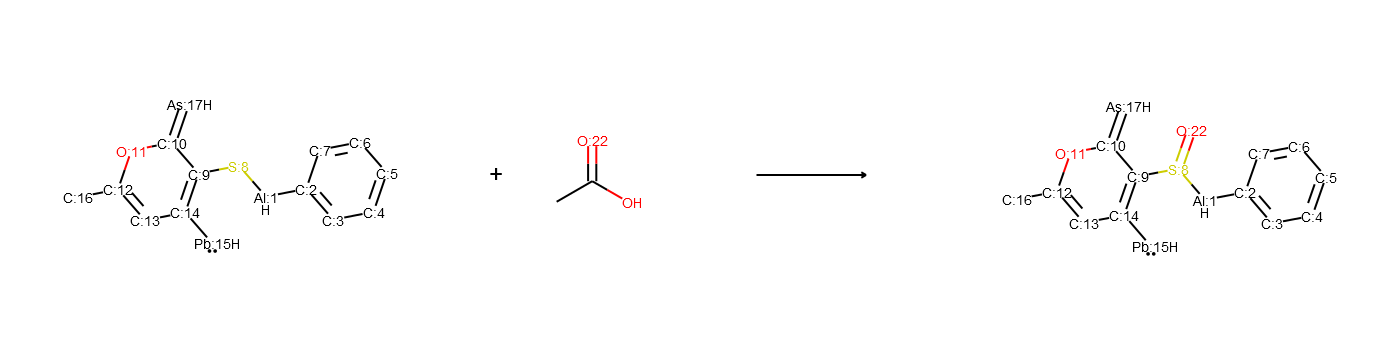

In [27]:
Draw.ReactionToImage(rdChemReactions.ReactionFromSmarts(changed_rxn_smi3, useSmiles=True), (350, 350))

## Idea 2: add atoms
- slight modification of code from Idea 1

In [48]:
def add_rdm_atom_tgt(rxn_smi, ele_list, counts=1, toprint=False, maxtries=100, keep_reagent=False):
    '''
    naively & randomly adds an atom to prod & does the same to corresp. atom in reactant (for chemical balance)
    
    rxn_smi: reaction SMILES in the form 'reactants>>product'
    ele_list: list of atomic numbers to be randomly picked from
    counts: # of atoms in prod to be changed
    toprint: whether to print info about changed atoms
    maxtries: # of tries for each count until func gives up & returns original rxn 
    keep_reagent: if True, returns rxn_smi w/ reagent(s) if originally present
    '''
    prod_smi = rxn_smi.split('>')[-1]
    rcts_smi = rxn_smi.split('>')[0].split('.')
    
    rcts_mol = [Chem.MolFromSmiles(rct_smi) for rct_smi in rcts_smi]
    rcts_molw = [Chem.RWMol(rct_mol) for rct_mol in rcts_mol] # need RWMol objects for flexibility
    rcts_molw_cand = copy.deepcopy(rcts_molw)
    
    prod_mol = Chem.MolFromSmiles(prod_smi)
    prod_molw = Chem.RWMol(prod_mol) # need RWMol objects for flexibility
    prod_molw_cand = copy.deepcopy(prod_molw)
    atom_idxs = [atom.GetIdx() for atom in prod_mol.GetAtoms() if atom.GetTotalNumHs() > 0]
    # only add bonds to atoms that have at least 1 hydrogen (which can be removed)
    
    iters = 0
    for count in np.arange(counts): 
        valid = False
        while not valid and iters < maxtries: # try while loop first, BUT not computationally efficient? 
            try: 
                rdm_atom_idx = random.choice(atom_idxs)
                rdm_ele = int(random.choice(ele_list))
                
                # add atom to product 
                added_atom = prod_molw_cand.AddAtom(Atom(rdm_ele))
                prod_molw_cand.AddBond(rdm_atom_idx, added_atom, rdkit.Chem.rdchem.BondType.SINGLE) # must specify bond type 
                totalH = prod_molw_cand.GetAtomWithIdx(rdm_atom_idx).GetTotalNumHs()
                prod_molw_cand.GetAtomWithIdx(rdm_atom_idx).SetNumExplicitHs(totalH-1) # necessary 
                
                Chem.SanitizeMol(prod_molw_cand) 
                if toprint:
                    print('rdm_atom_idx, rdm_ele:', rdm_atom_idx, rdm_ele, '\n')
                
                atom_map = prod_molw_cand.GetAtomWithIdx(rdm_atom_idx).GetProp('molAtomMapNumber')
                
                # find corresp. rct atom & add atom + bond 
                query_atom = rdqueries.HasIntPropWithValueQueryAtom('molAtomMapNumber', int(atom_map))
                match_atom = [rct_molw.GetAtomsMatchingQuery(query_atom) for rct_molw in rcts_molw_cand
                              if len(rct_molw.GetAtomsMatchingQuery(query_atom)) == 1]
                match_rct = Atom.GetOwningMol(match_atom[0][0]) # retrieves original pointer to rct molecule  
                base_idx = match_atom[0][0].GetIdx()
                
                added_atom = match_rct.AddAtom(Atom(rdm_ele))
                match_rct.AddBond(base_idx, added_atom, rdkit.Chem.rdchem.BondType.SINGLE) # must specify bond type 
                totalH = match_rct.GetAtomWithIdx(base_idx).GetTotalNumHs()
                match_rct.GetAtomWithIdx(base_idx).SetNumExplicitHs(totalH-1) # necessary 
                
                Chem.SanitizeMol(match_rct)
                               
                valid = True
                print('success!')
            except:
                print('Failed to add atom to both prod & rct')
                prod_molw_cand = copy.deepcopy(prod_molw) # reset candidates 
                rcts_molw_cand = copy.deepcopy(rcts_molw)
                iters += 1
                continue
        
        rcts_molw = copy.deepcopy(rcts_molw_cand)
        prod_molw = copy.deepcopy(prod_molw_cand) # successful candidate  
        atom_idxs.remove(rdm_atom_idx) # avoid changing the same atom more than once
        
    prod_smi = Chem.MolToSmiles(prod_molw, True)
    rcts_smi = [Chem.MolToSmiles(rct_molw, True) for rct_molw in rcts_molw]
    
    if keep_reagent:
        reag_smi = rxn_smi.split('>')[1]
        return '{}>{}>{}'.format('.'.join(rcts_smi), reag_smi, prod_smi)
    else:
        return '{}>>{}'.format('.'.join(rcts_smi), prod_smi)

###  original

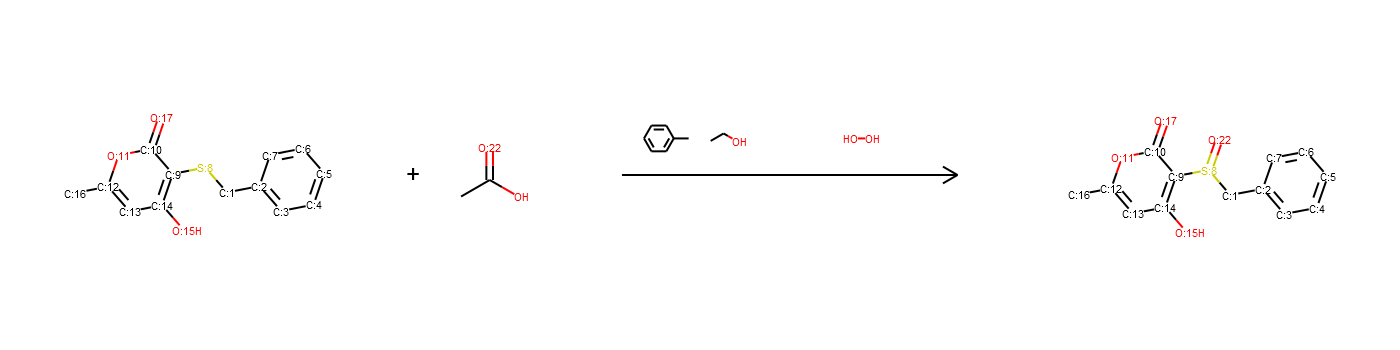

In [51]:
Draw.ReactionToImage(rdChemReactions.ReactionFromSmarts(sample_rxn_smi, useSmiles=True), (350, 350))

### changed (added 1 new atom of rdm ele @ rdm atom)

In [49]:
sample_rxn_smi = '[CH2:1]([c:2]1[cH:3][cH:4][cH:5][cH:6][cH:7]1)[S:8][c:9]1[c:10](=[O:17])[o:11][c:12]([CH3:16])[cH:13][c:14]1[OH:15].CC(O)=[O:22]>C1(C)C=CC=CC=1.C(O)C.OO>[CH2:1]([c:2]1[cH:3][cH:4][cH:5][cH:6][cH:7]1)[S:8]([c:9]1[c:10](=[O:17])[o:11][c:12]([CH3:16])[cH:13][c:14]1[OH:15])=[O:22]'
changed_rxn_smi = add_rdm_atom_tgt(sample_rxn_smi, refined_ele, counts=1, toprint=True, maxtries=20, keep_reagents=False)
changed_rxn_smi

rdm_atom_idx, rdm_ele: 6 83 

success!


'[BiH2][c:7]1[c:2]([CH2:1][S:8][c:9]2[c:10](=[O:17])[o:11][c:12]([CH3:16])[cH:13][c:14]2[OH:15])[cH:3][cH:4][cH:5][cH:6]1.CC(O)=[O:22]>>[BiH2][c:7]1[c:2]([CH2:1][S:8]([c:9]2[c:10](=[O:17])[o:11][c:12]([CH3:16])[cH:13][c:14]2[OH:15])=[O:22])[cH:3][cH:4][cH:5][cH:6]1'

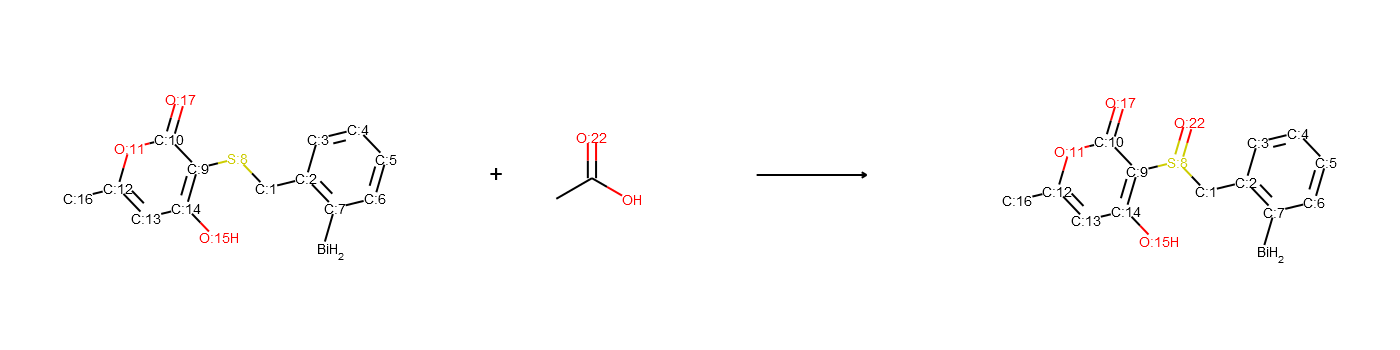

In [50]:
Draw.ReactionToImage(rdChemReactions.ReactionFromSmarts(changed_rxn_smi, useSmiles=True), (350, 350))

## Idea 3: how to replace whole subgroups (FGs)? (esp on atoms not present in product. i.e. LGs)

In [ ]:
# rdkit.Chem.rdmolops.CombineMols() 

## similarity screener 
idea: 
- from a subset of maybe 50,000 randomly chosen rxn (some reasonable number), calculate rxn similarity value to given rxn, and then choose top K rxn. 
- from those top K rxn, do augmentations (like random change of atoms etc.) <br> <br>

https://www.rdkit.org/docs/source/rdkit.Chem.Fingerprints.SimilarityScreener.html <br>
Could use TopN screener <br>

http://rdkit.org/docs/source/rdkit.Chem.AtomPairs.Utils.html?highlight=change <br>
Dice Similarity 

# older functions
**v2**: 
- uses while loop to check validity of changed product
- while loop inefficient? several instances where it failed to return a valid rxn --> is it better to select rdm_ele 
based on compatible DefaultValence values 
- SanitizeMol throws error when changing reactant atoms --> need to check validity for reactant also 
<br> <br> 

**v1**: 
- does not even check validity of changed product & reactants 
- atoms had wrong valences, resulting molecules fail SanitizeMol

In [ ]:
def change_rdm_atom_tgt_v2(rxn_smi, ele_list, counts=1, printidx=False):
    '''
    naively & randomly chooses an atom in prod & changes it to another random element,
    then changes atom-mapped reactant atom to that randomly chosen element (for chemical balance)
    
    rxn_smi: reaction SMILES in the form 'reactants>>product'
    ele_list: list of atomic numbers to be randomly picked from
    counts: # of atoms in prod to be changed
    printidx: whether to print changed_atoms dict
    '''
    changed_atoms = {} # (key, value) = (changed atom map number, changed atomic number) 
    prod_smi = rxn_smi.split('>')[-1]
    rcts_smi = rxn_smi.split('>')[0].split('.')
    
    # change product atom(s) 
    prod_mol = Chem.MolFromSmiles(prod_smi)
    prod_molw = Chem.RWMol(prod_mol)
    prod_molw_cand = copy.deepcopy(prod_molw)
    atom_idxs = list(range(0, prod_mol.GetNumAtoms()))
    
    for count in np.arange(counts): # choose new ele 1st or atom to be replaced 1st??? 
        rdm_atom_idx = random.choice(atom_idxs)
        valid = False
        while not valid: # try while loop first --> not computationally efficient! 
            try: 
                rdm_ele = int(random.choice(ele_list))
                prod_molw_cand.ReplaceAtom(rdm_atom_idx, Chem.Atom(rdm_ele), True, True)
                Chem.SanitizeMol(prod_molw)
                valid = True
            except:
                prod_molw_cand = copy.deepcopy(prod_molw) # need to reset candidate prod_molw # try without copy.deepcopy()
                continue
        
        prod_molw = copy.deepcopy(prod_molw_cand) # successful candidate # try without copy.deepcopy()
        atom_map = prod_molw.GetAtomWithIdx(rdm_atom_idx).GetProp('molAtomMapNumber')
        changed_atoms[atom_map] = rdm_ele
        atom_idxs.remove(rdm_atom_idx) # avoid changing the same atom more than once
        
    prod_smi = Chem.MolToSmiles(prod_molw, True) # note change to prod_molw from prod_mol
    if printidx:
        print(changed_atoms)
    
    # change reactant atom(s) corresponding to changed product atom(s) acc to atom mapping
    found = 0 
    query_atoms = [rdqueries.HasIntPropWithValueQueryAtom('molAtomMapNumber', int(atom_map)) 
                   for atom_map in changed_atoms.keys()]
    for i, rct_smi in enumerate(rcts_smi):                 
        rct_mol = Chem.MolFromSmiles(rct_smi)
        rct_molw = Chem.RWMol(rct_mol)
        
        for query_atom in query_atoms:
            matching_atoms = rct_mol.GetAtomsMatchingQuery(query_atom)
            
            for atom in matching_atoms:
                new_ele = changed_atoms[atom.GetProp('molAtomMapNumber')]
                rct_molw.ReplaceAtom(atom.GetIdx(), Chem.Atom(new_ele), True, True)
                Chem.SanitizeMol(rct_molw)
                found += 1
                
        rcts_smi[i] = Chem.MolToSmiles(rct_molw, True)
        if found >= counts: break
        
    return '{}>>{}'.format('.'.join(rcts_smi), prod_smi)

In [ ]:
def change_rdm_atom_tgt_v1(rxn_smi, ele_list, counts=1, printidx=False):
    '''
    naively & randomly chooses an atom in prod & changes it to another random element,
    then changes atom-mapped reactant atom to that randomly chosen element (for chemical balance)
    
    rxn_smi: reaction SMILES in the form 'reactants>>product'
    ele_list: list of atomic numbers to be randomly picked from
    counts: # of atoms in prod to be changed
    printidx: whether to print changed_atoms dict
    '''
    changed_atoms = {} # (key, value) = (changed atom map number, changed atomic number) 
    prod_smi = rxn_smi.split('>')[-1]
    rcts_smi = rxn_smi.split('>')[0].split('.')
    
    # change product atom(s) 
    prod_mol = Chem.MolFromSmiles(prod_smi)
    atom_idxs = list(range(0, prod_mol.GetNumAtoms()))
    for count in np.arange(counts):
        rdm_atom_idx = random.choice(atom_idxs)
        rdm_ele = int(random.choice(ele_list))
        prod_mol.GetAtomWithIdx(rdm_atom_idx).SetAtomicNum(rdm_ele)
        
        changed_atom_map = prod_mol.GetAtomWithIdx(rdm_atom_idx).GetProp('molAtomMapNumber')
        changed_atoms[changed_atom_map] = rdm_ele
        atom_idxs.remove(rdm_atom_idx) # avoid changing the same atom more than once
        
    prod_smi = Chem.MolToSmiles(prod_mol, True)
    if printidx:
        print(changed_atoms)
    
    # change reactant atom(s) corresponding to changed product atom(s) acc to atom mapping
    found = 0 
    for i, rct_smi in enumerate(rcts_smi):
        if found == counts: break
            
        rct_mol = Chem.MolFromSmiles(rct_smi)
        for atom in rct_mol.GetAtoms():
            if atom.HasProp('molAtomMapNumber'):
                if atom.GetProp('molAtomMapNumber') in changed_atoms.keys():
                    new_atomic_num = changed_atoms[atom.GetProp('molAtomMapNumber')] #retrieve from dict
                    rct_mol.GetAtomWithIdx(atom.GetIdx()).SetAtomicNum(new_atomic_num)
                    rcts_smi[i] = Chem.MolToSmiles(rct_mol, True) # update rcts_smi list
                    found += 1
                    if found == counts: break  
    
    return '{}>>{}'.format('.'.join(rcts_smi), prod_smi)

In [ ]:
rxn_smi = 'CC(=O)OC(C(=O)[NH:13][C@H:10]1[C@@H:9]2[N:8]([C:7]([C:29](=[O:30])[OH:31])=[C:6]([CH2:5]OC(C)=O)[CH2:28][S:27]2)[C:11]1=[O:12])c1ccccc1>>[CH3:5][C:6]1=[C:7]([C:29](=[O:30])[OH:31])[N:8]2[C@@H:9]([C@H:10]([NH2:13])[C:11]2=[O:12])[S:27][CH2:28]1'
prod_smi = rxn_smi.split('>')[-1]
prod_mol = Chem.MolFromSmiles(prod_smi)

rdm_atom_idx = 5
print(prod_mol.GetAtomWithIdx(rdm_atom_idx).GetTotalValence())

from rdkit.Chem import rdchem
table = rdchem.GetPeriodicTable()
print(list(table.GetValenceList(6)))

prod_mol.GetAtomWithIdx(rdm_atom_idx).SetAtomicNum(6)
Chem.SanitizeMol(prod_mol)
print(prod_mol.GetAtomWithIdx(rdm_atom_idx).GetTotalValence())
# PROBLEM!!!!!: even after changing O to C, TotalValence() remains 2 

prod_mol

### random stuff:
- Schneider's paper: dictionary based agent fingerprint shouldn't be hardcoded but rather selected dynamically from the given dataset (by some function that analyses the dataset and builds the dictionary)? but I suppose it is not a big issue